## Introduction

In this notebook, I perform a set of analyses on the relationship between the different variables and the mosquito number, as well as the probability of finding West Nile Virus (WNV) at any particular time and location.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

In [2]:
df = pd.read_csv('mosquito_data_part_2.csv') #load the data
df.head() #check the first 5 rows

,Year,Week,Address Block,Trap,Trap type,Date,Mosquito number,WNV Present,Species,Lat,Lon,Month
0,2019,39,100XX W OHARE AIRPORT,T910,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.977738,-87.880969,9
1,2019,39,52XX S KOLMAR AVE,T114,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.798211,-87.736925,9
2,2019,39,58XX N WESTERN AVE,T028,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.987245,-87.689417,9
3,2019,39,39XX N SPRINGFIELD AVE,T228,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.953664,-87.724987,9
4,2019,39,131XX S BRANDON AVE,T209,GRAVID,2019-09-26 00:09:00,9,negative,CULEX RESTUANS,41.657069,-87.546049,9


In [3]:
df.isna().sum() #check for null values

Year               0
Week               0
Address Block      0
Trap               0
Trap type          0
Date               0
Mosquito number    0
WNV Present        0
Species            0
Lat                0
Lon                0
Month              0
dtype: int64

In [4]:
df.shape #check the shape

(18495, 12)

In [5]:
df = df.drop_duplicates() #drop duplicate rows
df.shape #check if the shape changed

(17837, 12)

In [6]:
df = df.T.drop_duplicates().T #drop duplicate columns
df.shape #check the shape again

(17837, 12)

After removing some duplicate rows and zero duplicate columns, the dataframe has 17837 rows and 12 columns.

## Part 1 - Basic Analysis

### 1. Convert the WNV Present column into a binary column and create dummy variables from the Trap type column.

In [7]:
df1 = df #new dataframe to keep track
df1['WNV Present'] = df1['WNV Present'].map({'positive': 1, 'negative': 0}) #change the WNV column into binary

In [8]:
df1['WNV Present'].unique() #check that it changed into binary values 

array([0, 1])

In [9]:
df1 = pd.get_dummies(data = df1, columns=['Trap type'], dtype = 'uint8') #create dummy variables from Trap type column (returns boolean unless dtype is specified)

In [10]:
df1.head() #check the first 5 rows of the new df

,Year,Week,Address Block,Trap,Date,Mosquito number,WNV Present,Species,Lat,Lon,Month,Trap type_CDC,Trap type_GRAVID,Trap type_OVI,Trap type_SENTINEL
0,2019,39,100XX W OHARE AIRPORT,T910,2019-09-26 00:09:00,2,0,CULEX RESTUANS,41.977738,-87.880969,9,0,1,0,0
1,2019,39,52XX S KOLMAR AVE,T114,2019-09-26 00:09:00,1,0,CULEX RESTUANS,41.798211,-87.736925,9,0,1,0,0
2,2019,39,58XX N WESTERN AVE,T028,2019-09-26 00:09:00,2,0,CULEX RESTUANS,41.987245,-87.689417,9,0,1,0,0
3,2019,39,39XX N SPRINGFIELD AVE,T228,2019-09-26 00:09:00,1,0,CULEX RESTUANS,41.953664,-87.724987,9,0,1,0,0
4,2019,39,131XX S BRANDON AVE,T209,2019-09-26 00:09:00,9,0,CULEX RESTUANS,41.657069,-87.546049,9,0,1,0,0


### 2. What is the average number of mosquitoes for each month? What trends do you notice?

In [11]:
df1.groupby('Month')['Mosquito number'].sum()/df1.groupby('Month')['Mosquito number'].count() #calculate the mean mosquito number for each month

Month
5      2.761905
6     10.039783
7     11.053295
8     11.605926
9      8.156741
10     5.377778
Name: Mosquito number, dtype: object

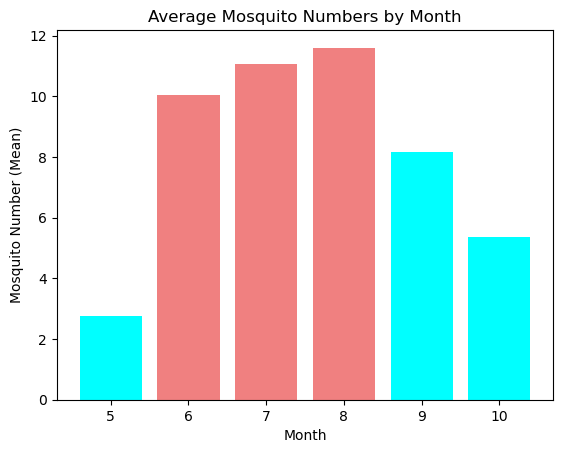

In [12]:
#visualize the average number of mosquitoes for each month with a bar chart
plt.figure()
plt.bar((df1.groupby('Month')['Mosquito number'].sum()/df1.groupby('Month')['Mosquito number'].count()).index,
        (df1.groupby('Month')['Mosquito number'].sum()/df1.groupby('Month')['Mosquito number'].count()).values,
        color = ['aqua', 'lightcoral', 'lightcoral', 'lightcoral', 'aqua', 'aqua'])
plt.title('Average Mosquito Numbers by Month')
plt.ylabel('Mosquito Number (Mean)')
plt.xlabel('Month')
plt.show()

Mosquito numbers seem to **increase in summer months**, with a **peak in August**, and **decrease in the fall and spring**. Fall has higher average number of mosquitoes compared to the spring. I assume we don't have records for November through April because the numbers are very very low. 

## Part 2 - Statistical Analysis

### 1. Is there a statistically significant difference between the different mosquito species when looking at the occurrence of West Nile Virus?

In [13]:
df1.groupby('Species')['WNV Present'].value_counts() #compare the counts of traps with a given mosquito species that has WNV or not

Species           WNV Present
CULEX PIPIENS     0              4074
                  1              1237
CULEX RESTUANS    0              9309
                  1              2078
CULEX SALINARIUS  0               215
                  1                 7
CULEX TERRITANS   0               903
                  1                14
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

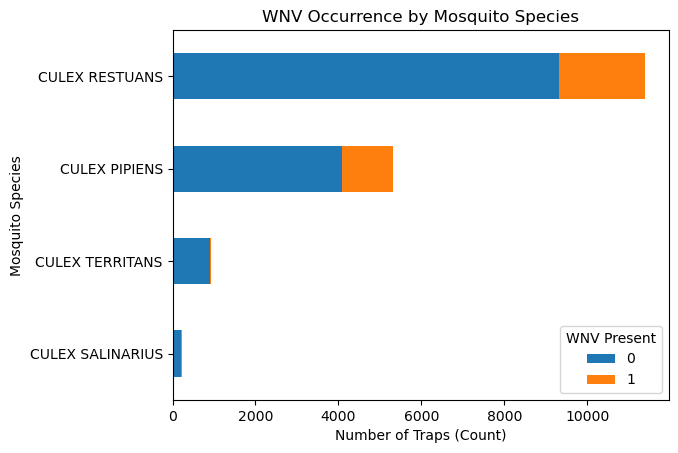

In [14]:
#visalize the distribution in numbers 
plt.figure()
df1.groupby('Species')['WNV Present'].value_counts(normalize = False).unstack().sort_values(1, ascending = True).plot(kind = 'barh', stacked = True)
plt.title('WNV Occurrence by Mosquito Species')
plt.xlabel('Number of Traps (Count)')
plt.ylabel('Mosquito Species')
plt.show()

In [15]:
df1.groupby('Species')['WNV Present'].mean() #compare the rate of WNV accross mosquito species

Species
CULEX PIPIENS       0.232913
CULEX RESTUANS      0.182489
CULEX SALINARIUS    0.031532
CULEX TERRITANS     0.015267
Name: WNV Present, dtype: float64

<Figure size 640x480 with 0 Axes>

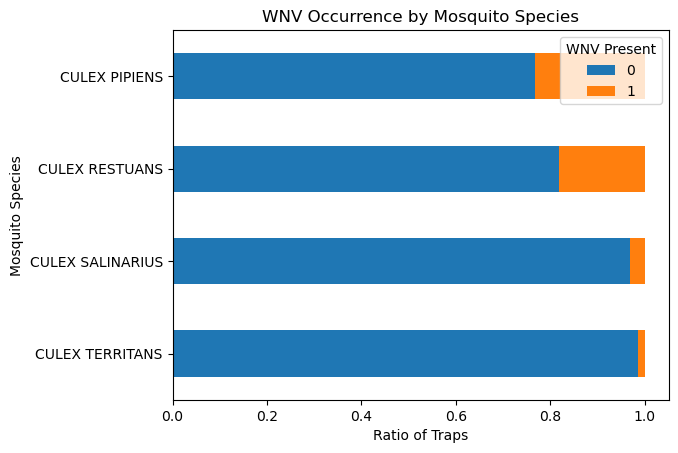

In [16]:
#visalize the distribution with rates 
plt.figure()
df1.groupby('Species')['WNV Present'].value_counts(normalize = True).unstack().sort_values(1, ascending = True).plot(kind = 'barh', stacked = True)
plt.title('WNV Occurrence by Mosquito Species')
plt.xlabel('Ratio of Traps')
plt.ylabel('Mosquito Species')
plt.show()

There is clearly a contrast between different mosquito species. Pipiens and Restuans have higher rates of WNV than Salinarius and Territans. Pipiens have a higher rate than Restuans, and Salinarius have a higher rate of WNV than Territans.

Next, I check if these correlations are statistically significant.

**Null Hypohthesis:** There is no relationship between mosquito species and WNV occurrence. (They are independent.)

**Alternative Hypothesis:** There is some relationship between mosquito species and WMV occurrence. (They are not independent.)


In [17]:
df1.groupby('Species')['WNV Present'].value_counts() #compare the counts of traps with a given mosquito species that has WNV or not

Species           WNV Present
CULEX PIPIENS     0              4074
                  1              1237
CULEX RESTUANS    0              9309
                  1              2078
CULEX SALINARIUS  0               215
                  1                 7
CULEX TERRITANS   0               903
                  1                14
Name: count, dtype: int64

In [18]:
#create a contingency table with the positive and negative WNV numbers given above for each species

data_cont = {'Pipiens': [4074,1237], 'Restuans':[9309,2078], 'Salinarius':[215,7], 'Territans': [903,14]}

df_cont = pd.DataFrame(data_cont, index=['WNV not Present', 'WNV Present'])

display(df_cont)

,Pipiens,Restuans,Salinarius,Territans
WNV not Present,4074,9309,215,903
WNV Present,1237,2078,7,14


In [19]:
stats.chi2_contingency(df_cont) #run the chi-squared contingency test

Chi2ContingencyResult(statistic=288.313097009138, pvalue=3.3649395840995687e-62, dof=3, expected_freq=array([[4317.69978135, 9257.3239334 ,  180.48001346,  745.49627179],
       [ 993.30021865, 2129.6760666 ,   41.51998654,  171.50372821]]))

**Conclusion:** With a p-value of 3.3649395840995687e-62, we can reject the null hypothesis that the mosquito species and the WNV rate are independent. It appears that there is some relationship between mosquito species and WNV occurrence.

### 2. Which columns are positively correlated with the number of mosquitoes caught? Which columns are negatively correlated? Are these correlations statistically significant?

Before we look at the correlations and perform a statistical analysis on the whole dataframe, we need to make sure all of the independent variables are numeric. For this we need to look at the distribution of mosquito numbers by each independent variable and decide whether we group different categories in a variable together or create dummy variables for all the categories within in. If there are too many categories within an independent variable, and if another column provides that information, we drop that column. Next, I do the preprocessing of the data. 

## Data Preprocessing

In [20]:
df1.columns

Index(['Year', 'Week', 'Address Block', 'Trap', 'Date', 'Mosquito number',
       'WNV Present', 'Species', 'Lat', 'Lon', 'Month', 'Trap type_CDC',
       'Trap type_GRAVID', 'Trap type_OVI', 'Trap type_SENTINEL'],
      dtype='object')

### The Year Variable

In [21]:
#calculate average mosquito numbers for each year
df1.groupby('Year')['Mosquito number'].sum()/df1.groupby('Year')['Mosquito number'].count()

Year
2007    11.470085
2008     3.945122
2009      4.83791
2010     5.462166
2011     6.687558
2012     8.089947
2013    14.660038
2014    14.958291
2015     9.216771
2016    19.113074
2017     8.787645
2018    10.489796
2019     8.324324
Name: Mosquito number, dtype: object

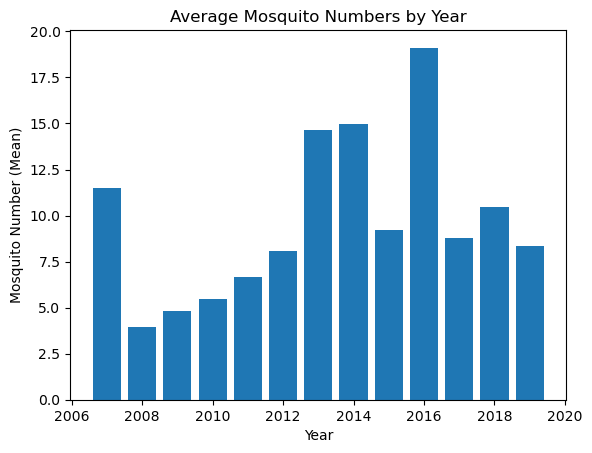

In [22]:
#visualize the average mosquito numbers for each year with a bar chart
plt.figure()
plt.bar((df1.groupby('Year')['Mosquito number'].sum()/df1.groupby('Year')['Mosquito number'].count()).index,
        (df1.groupby('Year')['Mosquito number'].sum()/df1.groupby('Year')['Mosquito number'].count()).values)
plt.title('Average Mosquito Numbers by Year')
plt.ylabel('Mosquito Number (Mean)')
plt.xlabel('Year')
plt.show()

The average mosquito number is the highest in 2016. The numbers seem to be high in 2007 and then, decrease sharply in 2008. After that, they increase  gradually until 2013. Numbers in 2013 and 2014 are similar, followed by a sharp decrease in 2015. Then the numbers jump in 2016, to drop sharply in 2017. They remain similarly low in 2018 and 2019. For now, number for each year seems distinct enough for us to create a dummy variable for each year. 

In [23]:
#create dummy variables from Year column (returns boolean unless dtype is specified)
df1 = pd.get_dummies(data = df1, columns=['Year'], dtype = 'uint8')

In [24]:
df1.head() #check the first 5 rows

,Week,Address Block,Trap,Date,Mosquito number,WNV Present,Species,Lat,Lon,Month,...,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019
0,39,100XX W OHARE AIRPORT,T910,2019-09-26 00:09:00,2,0,CULEX RESTUANS,41.977738,-87.880969,9,...,0,0,0,0,0,0,0,0,0,1
1,39,52XX S KOLMAR AVE,T114,2019-09-26 00:09:00,1,0,CULEX RESTUANS,41.798211,-87.736925,9,...,0,0,0,0,0,0,0,0,0,1
2,39,58XX N WESTERN AVE,T028,2019-09-26 00:09:00,2,0,CULEX RESTUANS,41.987245,-87.689417,9,...,0,0,0,0,0,0,0,0,0,1
3,39,39XX N SPRINGFIELD AVE,T228,2019-09-26 00:09:00,1,0,CULEX RESTUANS,41.953664,-87.724987,9,...,0,0,0,0,0,0,0,0,0,1
4,39,131XX S BRANDON AVE,T209,2019-09-26 00:09:00,9,0,CULEX RESTUANS,41.657069,-87.546049,9,...,0,0,0,0,0,0,0,0,0,1


### The Month Variable

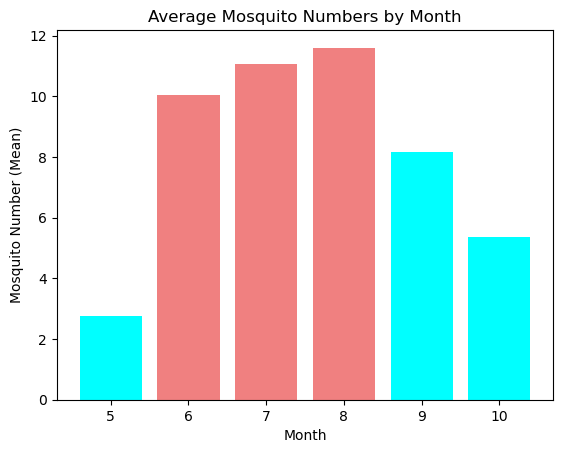

In [25]:
#repeat the visualization of the average number of mosquitoes for each month with a bar chart
#visualize the average number of mosquitoes for each month with a bar chart
plt.figure()
plt.bar((df1.groupby('Month')['Mosquito number'].sum()/df1.groupby('Month')['Mosquito number'].count()).index,
        (df1.groupby('Month')['Mosquito number'].sum()/df1.groupby('Month')['Mosquito number'].count()).values,
        color = ['aqua', 'lightcoral', 'lightcoral', 'lightcoral', 'aqua', 'aqua'])
plt.title('Average Mosquito Numbers by Month')
plt.ylabel('Mosquito Number (Mean)')
plt.xlabel('Month')
plt.show()

Summer months seem to be a cluster in terms of the average mosquito numbers. We can change the month column to encode whether it is summer or not.

In [26]:
#create a new column encoding whether it is a summer month
df1['Is_Summer_Month'] = df1['Month'].map({5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0})

In [27]:
df1 = df1.drop(columns = ['Month']) #drop the Month column

In [28]:
df1.head() #check the first 5 rows

,Week,Address Block,Trap,Date,Mosquito number,WNV Present,Species,Lat,Lon,Trap type_CDC,...,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Is_Summer_Month
0,39,100XX W OHARE AIRPORT,T910,2019-09-26 00:09:00,2,0,CULEX RESTUANS,41.977738,-87.880969,0,...,0,0,0,0,0,0,0,0,1,0
1,39,52XX S KOLMAR AVE,T114,2019-09-26 00:09:00,1,0,CULEX RESTUANS,41.798211,-87.736925,0,...,0,0,0,0,0,0,0,0,1,0
2,39,58XX N WESTERN AVE,T028,2019-09-26 00:09:00,2,0,CULEX RESTUANS,41.987245,-87.689417,0,...,0,0,0,0,0,0,0,0,1,0
3,39,39XX N SPRINGFIELD AVE,T228,2019-09-26 00:09:00,1,0,CULEX RESTUANS,41.953664,-87.724987,0,...,0,0,0,0,0,0,0,0,1,0
4,39,131XX S BRANDON AVE,T209,2019-09-26 00:09:00,9,0,CULEX RESTUANS,41.657069,-87.546049,0,...,0,0,0,0,0,0,0,0,1,0


### The Species Variable

In [29]:
#calculate average number of mosquitoes for each species
df1.groupby('Species')['Mosquito number'].sum()/df1.groupby('Species')['Mosquito number'].count()

Species
CULEX PIPIENS       10.856148
CULEX RESTUANS      11.121542
CULEX SALINARIUS     2.009009
CULEX TERRITANS      1.973828
Name: Mosquito number, dtype: object

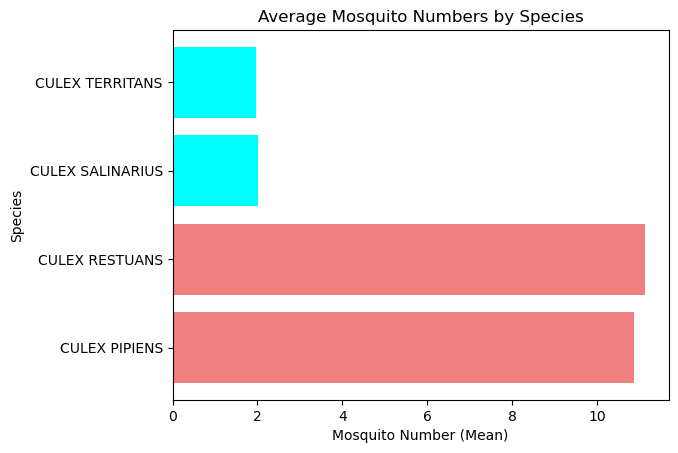

In [30]:
#visualize the average mosquito numbers for each species with a bar chart
plt.figure()
plt.barh((df1.groupby('Species')['Mosquito number'].sum()/df1.groupby('Species')['Mosquito number'].count()).index,
        (df1.groupby('Species')['Mosquito number'].sum()/df1.groupby('Species')['Mosquito number'].count()).values,
        color = ['lightcoral', 'lightcoral', 'aqua', 'aqua'])
plt.title('Average Mosquito Numbers by Species')
plt.xlabel('Mosquito Number (Mean)')
plt.ylabel('Species')
plt.show()

From the barchart, it is clear that the Restuans and Pipiens have a higher average number than Territans and Salinarius. So we can create a column that encodes whether a given species belongs to the Restuans/Pipiens Species OR NOT (i.e., Territans/Salinarius).

In [31]:
#create a new column encding wheather a given mosquito species belongs to Pipiens or Restuans OR Territans or Salinarius.
df1['Is_RestuansPipiens'] = df1['Species'].map({'CULEX PIPIENS': 1, 'CULEX RESTUANS': 1, 
                                                    'CULEX TERRITANS': 0, 'CULEX SALINARIUS': 0})

In [32]:
df1.head() #check the first 5 rows.

,Week,Address Block,Trap,Date,Mosquito number,WNV Present,Species,Lat,Lon,Trap type_CDC,...,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Is_Summer_Month,Is_RestuansPipiens
0,39,100XX W OHARE AIRPORT,T910,2019-09-26 00:09:00,2,0,CULEX RESTUANS,41.977738,-87.880969,0,...,0,0,0,0,0,0,0,1,0,1
1,39,52XX S KOLMAR AVE,T114,2019-09-26 00:09:00,1,0,CULEX RESTUANS,41.798211,-87.736925,0,...,0,0,0,0,0,0,0,1,0,1
2,39,58XX N WESTERN AVE,T028,2019-09-26 00:09:00,2,0,CULEX RESTUANS,41.987245,-87.689417,0,...,0,0,0,0,0,0,0,1,0,1
3,39,39XX N SPRINGFIELD AVE,T228,2019-09-26 00:09:00,1,0,CULEX RESTUANS,41.953664,-87.724987,0,...,0,0,0,0,0,0,0,1,0,1
4,39,131XX S BRANDON AVE,T209,2019-09-26 00:09:00,9,0,CULEX RESTUANS,41.657069,-87.546049,0,...,0,0,0,0,0,0,0,1,0,1


In [33]:
df1 = df1.drop(columns = ['Species']) #drop the Species column

df1.columns #check the column names

Index(['Week', 'Address Block', 'Trap', 'Date', 'Mosquito number',
       'WNV Present', 'Lat', 'Lon', 'Trap type_CDC', 'Trap type_GRAVID',
       'Trap type_OVI', 'Trap type_SENTINEL', 'Year_2007', 'Year_2008',
       'Year_2009', 'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013',
       'Year_2014', 'Year_2015', 'Year_2016', 'Year_2017', 'Year_2018',
       'Year_2019', 'Is_Summer_Month', 'Is_RestuansPipiens'],
      dtype='object')

### The Week Variable

Because months are also recorded as an independent variable in the data, week variable would cause co-linearity. The two barcharts below visualize this.

In [34]:
#calculate average number of mosquitoes for each week
df1.groupby('Week')['Mosquito number'].sum()/df1.groupby('Week')['Mosquito number'].count()

Week
20     3.275862
21     5.166667
22     4.906977
23     8.244592
24    10.826683
25    10.876129
26        9.375
27    10.491398
28    11.558528
29    10.043514
30    11.242447
31    13.276882
32    12.623096
33    12.239549
34     9.720128
35    10.055871
36    11.167021
37     7.418182
38     6.481928
39     5.112245
40     3.702128
Name: Mosquito number, dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

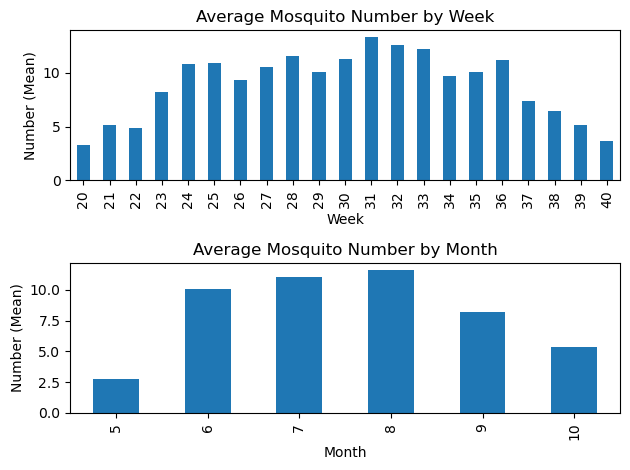

In [35]:
#compare average number of mosquitoes for each month and week
plt.figure()
plt.subplots(2,1)

plt.subplot(2,1,1)
plt.title('Average Mosquito Number by Week')
df1.groupby('Week')['Mosquito number'].mean().plot(kind='bar') #mean is giving the same numbers as summing and dividing by the count of observations
plt.ylabel('Number (Mean)')


plt.subplot(2,1,2)
plt.title('Average Mosquito Number by Month')
df.groupby('Month')['Mosquito number'].mean().plot(kind='bar')
plt.ylabel('Number (Mean)')

plt.tight_layout()
plt.show

In [36]:
#drop the Week column
df1 = df1.drop(columns = ['Week'])

#check the column names
df1.columns

Index(['Address Block', 'Trap', 'Date', 'Mosquito number', 'WNV Present',
       'Lat', 'Lon', 'Trap type_CDC', 'Trap type_GRAVID', 'Trap type_OVI',
       'Trap type_SENTINEL', 'Year_2007', 'Year_2008', 'Year_2009',
       'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014',
       'Year_2015', 'Year_2016', 'Year_2017', 'Year_2018', 'Year_2019',
       'Is_Summer_Month', 'Is_RestuansPipiens'],
      dtype='object')

### The Date Variable

We already have the year and month as independent variables. However, we can extract the time from the Date column and use it as an independent variable. The chart below shows how average mosquito numbers change during different times in a day. 

In [37]:
df1['Date'] = df1['Date'].astype('datetime64[ns]')#change the datatype of the Date column to Datetime

df1['Hour'] = df1['Date'].dt.hour#create the Hour column 
df1.columns

Index(['Address Block', 'Trap', 'Date', 'Mosquito number', 'WNV Present',
       'Lat', 'Lon', 'Trap type_CDC', 'Trap type_GRAVID', 'Trap type_OVI',
       'Trap type_SENTINEL', 'Year_2007', 'Year_2008', 'Year_2009',
       'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014',
       'Year_2015', 'Year_2016', 'Year_2017', 'Year_2018', 'Year_2019',
       'Is_Summer_Month', 'Is_RestuansPipiens', 'Hour'],
      dtype='object')

In [38]:
#calculate the average mosquito numbers for recorded hours
df1.groupby('Hour')['Mosquito number'].mean()

Hour
0     10.61234
2     6.696875
3     4.153846
4     3.418605
8          5.0
11    2.212121
Name: Mosquito number, dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

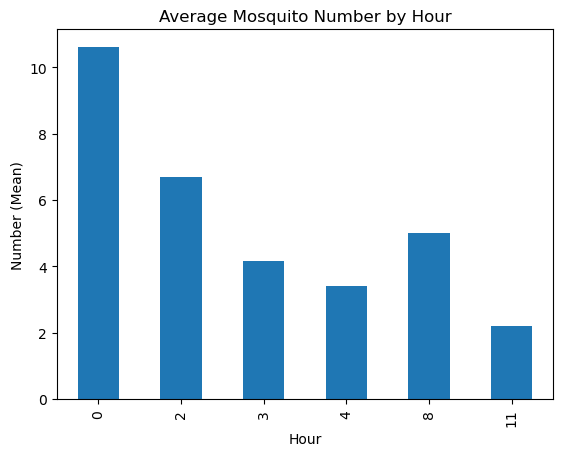

In [39]:
plt.figure()
plt.title('Average Mosquito Number by Hour')
df1.groupby('Hour')['Mosquito number'].mean().plot(kind='bar')
plt.ylabel('Number (Mean)')
plt.show

Average mosquito number is at the **highest around midnight** (i.e., 0). From 2 to 4 the number is gradually decreasing. There is a slight increase at 8. The lowest is at 11. I assume these hours are during night and the numbers are not recorded during the day. The output of the code below shows that the majority of the data is from midnight too. I will **create a new column that encodes whether the time of day is midnight or not**.

In [40]:
#list the value counts for hour of records
df1['Hour'].value_counts()

Hour
0     17309
2       320
3        78
11       66
4        43
8        21
Name: count, dtype: int64

In [41]:
#create a column that encodes whether time of day is midnight
df1['Is_Midnight'] = df1['Hour'].map({0: 1, 2: 0, 3: 0, 4: 0, 8: 0, 11: 0})

In [42]:
df1.head() #check the first 5 rows

,Address Block,Trap,Date,Mosquito number,WNV Present,Lat,Lon,Trap type_CDC,Trap type_GRAVID,Trap type_OVI,...,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Is_Summer_Month,Is_RestuansPipiens,Hour,Is_Midnight
0,100XX W OHARE AIRPORT,T910,2019-09-26 00:09:00,2,0,41.977738,-87.880969,0,1,0,...,0,0,0,0,0,1,0,1,0,1
1,52XX S KOLMAR AVE,T114,2019-09-26 00:09:00,1,0,41.798211,-87.736925,0,1,0,...,0,0,0,0,0,1,0,1,0,1
2,58XX N WESTERN AVE,T028,2019-09-26 00:09:00,2,0,41.987245,-87.689417,0,1,0,...,0,0,0,0,0,1,0,1,0,1
3,39XX N SPRINGFIELD AVE,T228,2019-09-26 00:09:00,1,0,41.953664,-87.724987,0,1,0,...,0,0,0,0,0,1,0,1,0,1
4,131XX S BRANDON AVE,T209,2019-09-26 00:09:00,9,0,41.657069,-87.546049,0,1,0,...,0,0,0,0,0,1,0,1,0,1


In [43]:
df1 = df1.drop(columns=['Hour', 'Date']) #drop the Hour and Date columns

df1.columns #check column names

Index(['Address Block', 'Trap', 'Mosquito number', 'WNV Present', 'Lat', 'Lon',
       'Trap type_CDC', 'Trap type_GRAVID', 'Trap type_OVI',
       'Trap type_SENTINEL', 'Year_2007', 'Year_2008', 'Year_2009',
       'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014',
       'Year_2015', 'Year_2016', 'Year_2017', 'Year_2018', 'Year_2019',
       'Is_Summer_Month', 'Is_RestuansPipiens', 'Is_Midnight'],
      dtype='object')

### The Address Block Variable

In [44]:
len(df1['Address Block'].unique()) #get the number of unique address blocks recorded

154

**This is TOO MANY!**  As shown below, when we try to visualize the average number of mosquitoes for each address block, it is impossible to see any patterns.

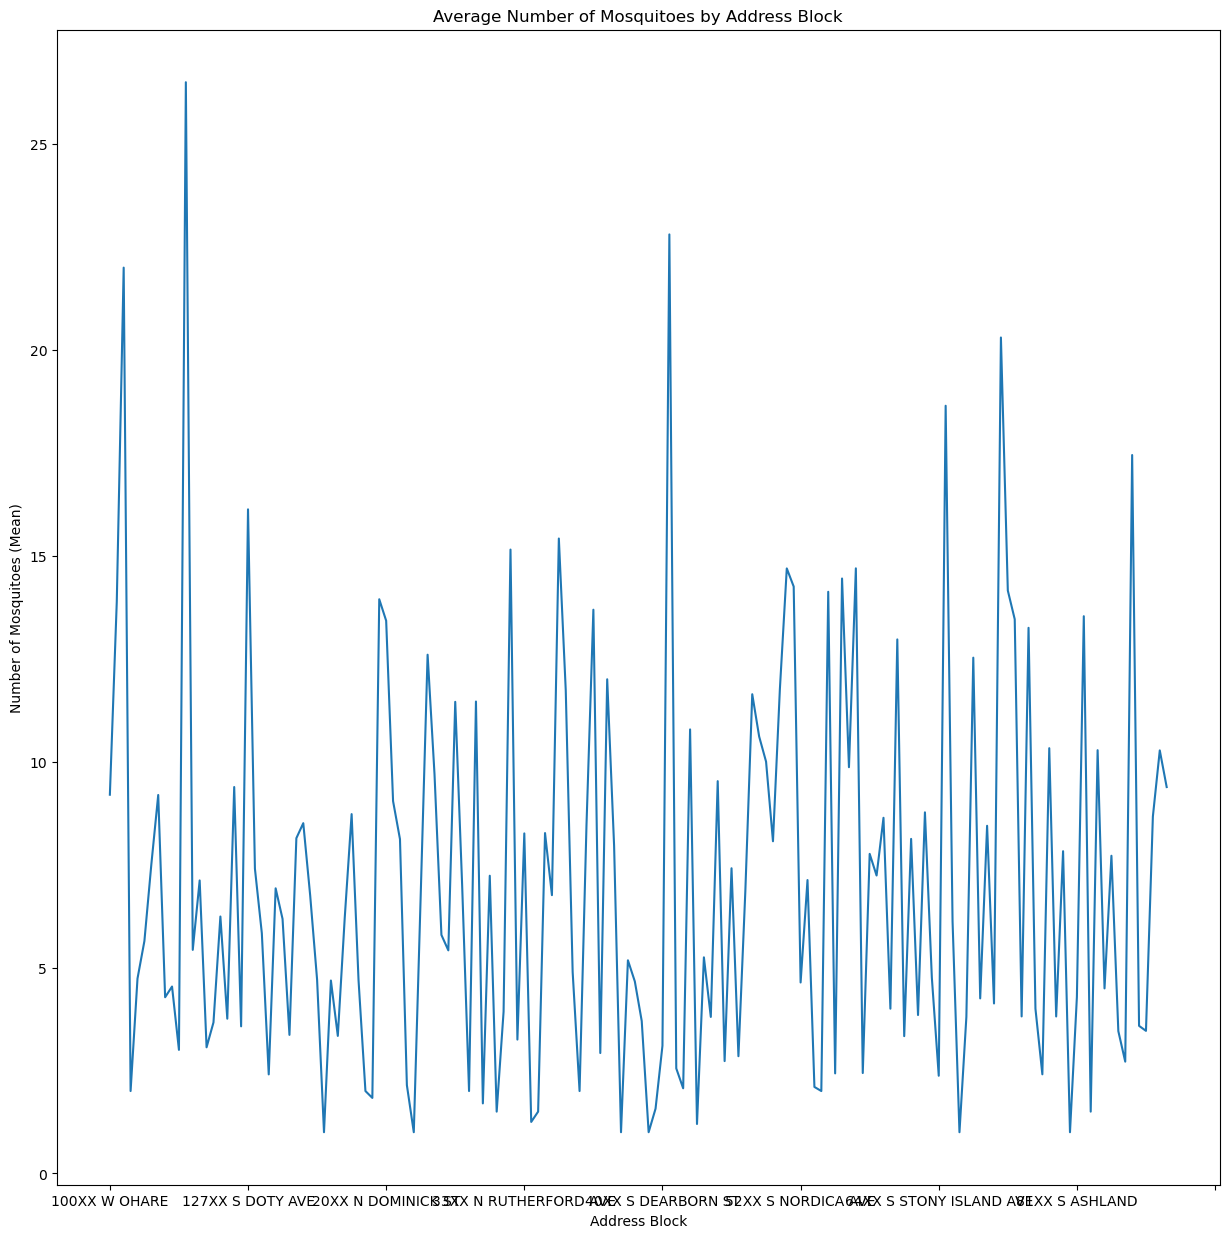

In [45]:
plt.figure(figsize = (15,15))
plt.title('Average Number of Mosquitoes by Address Block')
plt.xlabel('Address Block')
plt.ylabel('Number of Mosquitoes (Mean)')
df1.groupby('Address Block')['Mosquito number'].mean().plot(kind = 'line')
plt.show()

We already have the location information encoded as latitude and longitude. So there is no need to keep the Address Block column and try to change it into a numeric column. Next, **I drop this column**.

In [46]:
df1 = df1.drop(columns=['Address Block']) #drop the Address Block column

df1.columns #check column names

Index(['Trap', 'Mosquito number', 'WNV Present', 'Lat', 'Lon', 'Trap type_CDC',
       'Trap type_GRAVID', 'Trap type_OVI', 'Trap type_SENTINEL', 'Year_2007',
       'Year_2008', 'Year_2009', 'Year_2010', 'Year_2011', 'Year_2012',
       'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016', 'Year_2017',
       'Year_2018', 'Year_2019', 'Is_Summer_Month', 'Is_RestuansPipiens',
       'Is_Midnight'],
      dtype='object')

### The Trap Variable

In [47]:
len(df1['Trap'].unique()) #get the number of unique Traps recorded

190

**This is TOO MANY!**  Similar to Address Blocks, when we try to visualize the average number of mosquitoes for each Trap, it is impossible to see any patterns. 

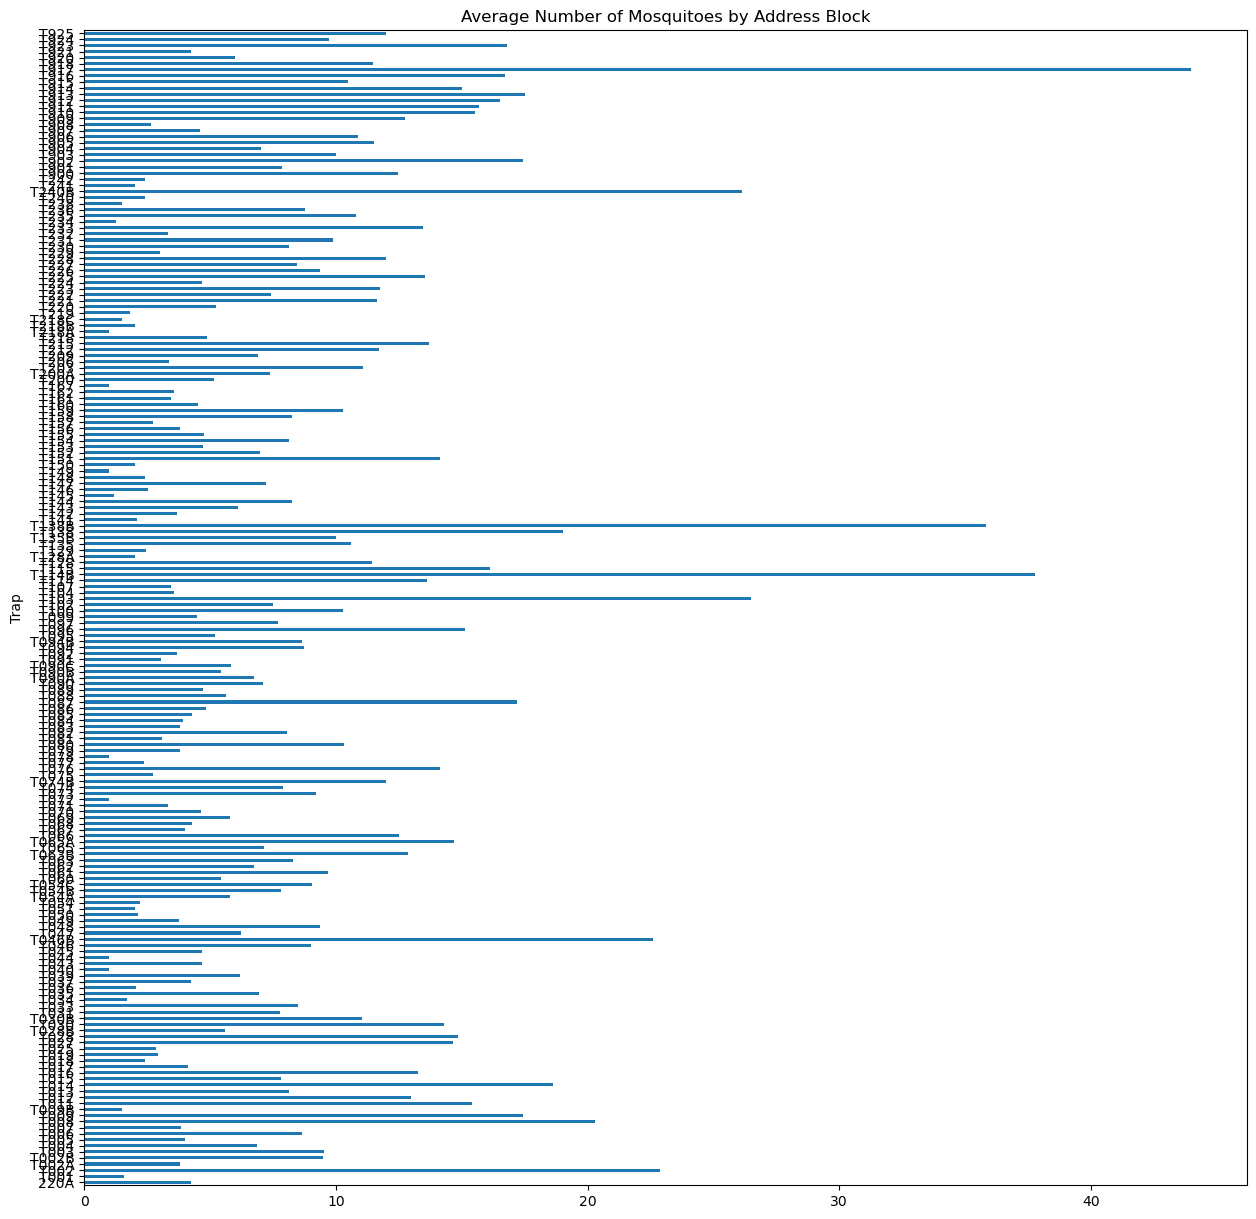

In [48]:
plt.figure(figsize = (15,15))
plt.title('Average Number of Mosquitoes by Address Block')
plt.xlabel('Address Block')
plt.ylabel('Number of Mosquitoes (Mean)')
df1.groupby('Trap')['Mosquito number'].mean().plot(kind = 'barh')
plt.show()

We can only see that certain traps caught much higher numbers of mosquitoes than others. We already have the Trap type and location (as lat - lon) encoded in the dataframe. **I also drop the Trap column**.

In [49]:
df1 = df1.drop(columns=['Trap']) #drop the Address Block column

df1.columns #check column names

Index(['Mosquito number', 'WNV Present', 'Lat', 'Lon', 'Trap type_CDC',
       'Trap type_GRAVID', 'Trap type_OVI', 'Trap type_SENTINEL', 'Year_2007',
       'Year_2008', 'Year_2009', 'Year_2010', 'Year_2011', 'Year_2012',
       'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016', 'Year_2017',
       'Year_2018', 'Year_2019', 'Is_Summer_Month', 'Is_RestuansPipiens',
       'Is_Midnight'],
      dtype='object')

### The Dummied Variables

We need to drop one from each dummied variable: Trap type and Year.

In [50]:
#calculate the total mosquito numbers for each trap type
df.groupby('Trap type')['Mosquito number'].sum()

Trap type
CDC           9514
GRAVID      171905
OVI              1
SENTINEL      5134
Name: Mosquito number, dtype: object

In [51]:
#calculate the mean mosquito numbers for each trap type
df.groupby('Trap type')['Mosquito number'].sum()/df.groupby('Trap type')['Mosquito number'].count()

Trap type
CDC         17.984877
GRAVID        10.0541
OVI               1.0
SENTINEL    24.564593
Name: Mosquito number, dtype: object

Dropping Trap type_OVI seems like the best option but it might not be enough to prevent high colinearity since there is only one data point with one mosquito caught with this trap type. If the colinearity is too high we might need to drop another trap type at another iteration.

Let's double check the average mosquito number in each year.

In [52]:
df.groupby('Year')['Mosquito number'].sum()/df.groupby('Year')['Mosquito number'].count()

Year
2007    11.470085
2008     3.945122
2009      4.83791
2010     5.462166
2011     6.687558
2012     8.089947
2013    14.660038
2014    14.958291
2015     9.216771
2016    19.113074
2017     8.787645
2018    10.489796
2019     8.324324
Name: Mosquito number, dtype: object

Let's see what is the overall mean number of mosquitoes caught.

In [53]:
df['Mosquito number'].mean()

10.4588215507092

Let's drop the year 2018 since the mean mosquito number is almost the same as the overall mean.

In [54]:
#drop ONE from each dummied variable

df2 = df1.drop(columns=['Trap type_OVI', 'Year_2018'])

df2.columns

Index(['Mosquito number', 'WNV Present', 'Lat', 'Lon', 'Trap type_CDC',
       'Trap type_GRAVID', 'Trap type_SENTINEL', 'Year_2007', 'Year_2008',
       'Year_2009', 'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013',
       'Year_2014', 'Year_2015', 'Year_2016', 'Year_2017', 'Year_2019',
       'Is_Summer_Month', 'Is_RestuansPipiens', 'Is_Midnight'],
      dtype='object')

In [55]:
df2.info() #sanity check

<class 'pandas.core.frame.DataFrame'>
Index: 17837 entries, 0 to 18493
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Mosquito number     17837 non-null  object
 1   WNV Present         17837 non-null  int64 
 2   Lat                 17837 non-null  object
 3   Lon                 17837 non-null  object
 4   Trap type_CDC       17837 non-null  uint8 
 5   Trap type_GRAVID    17837 non-null  uint8 
 6   Trap type_SENTINEL  17837 non-null  uint8 
 7   Year_2007           17837 non-null  uint8 
 8   Year_2008           17837 non-null  uint8 
 9   Year_2009           17837 non-null  uint8 
 10  Year_2010           17837 non-null  uint8 
 11  Year_2011           17837 non-null  uint8 
 12  Year_2012           17837 non-null  uint8 
 13  Year_2013           17837 non-null  uint8 
 14  Year_2014           17837 non-null  uint8 
 15  Year_2015           17837 non-null  uint8 
 16  Year_2016           17837 n

We need to change the data types of the object type columns to integer. These are `Mosquito number`, `Lat`, and `Lon`.

In [56]:
df2['Mosquito number'] = df2['Mosquito number'].astype('int64')

df2[['Lat', 'Lon']] = df2[['Lat', 'Lon']].astype('float')

df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17837 entries, 0 to 18493
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Mosquito number     17837 non-null  int64  
 1   WNV Present         17837 non-null  int64  
 2   Lat                 17837 non-null  float64
 3   Lon                 17837 non-null  float64
 4   Trap type_CDC       17837 non-null  uint8  
 5   Trap type_GRAVID    17837 non-null  uint8  
 6   Trap type_SENTINEL  17837 non-null  uint8  
 7   Year_2007           17837 non-null  uint8  
 8   Year_2008           17837 non-null  uint8  
 9   Year_2009           17837 non-null  uint8  
 10  Year_2010           17837 non-null  uint8  
 11  Year_2011           17837 non-null  uint8  
 12  Year_2012           17837 non-null  uint8  
 13  Year_2013           17837 non-null  uint8  
 14  Year_2014           17837 non-null  uint8  
 15  Year_2015           17837 non-null  uint8  
 16  Year_2016

## The Correlations

Now finally we can look at the correlation between the dependent variable - Mosquito number - and the independent variables.

In [57]:
corrDf2 = df2.corr() #this will not be readable

In [58]:
mask = np.triu(corrDf2) #triu = upper triangle, mask will help readability

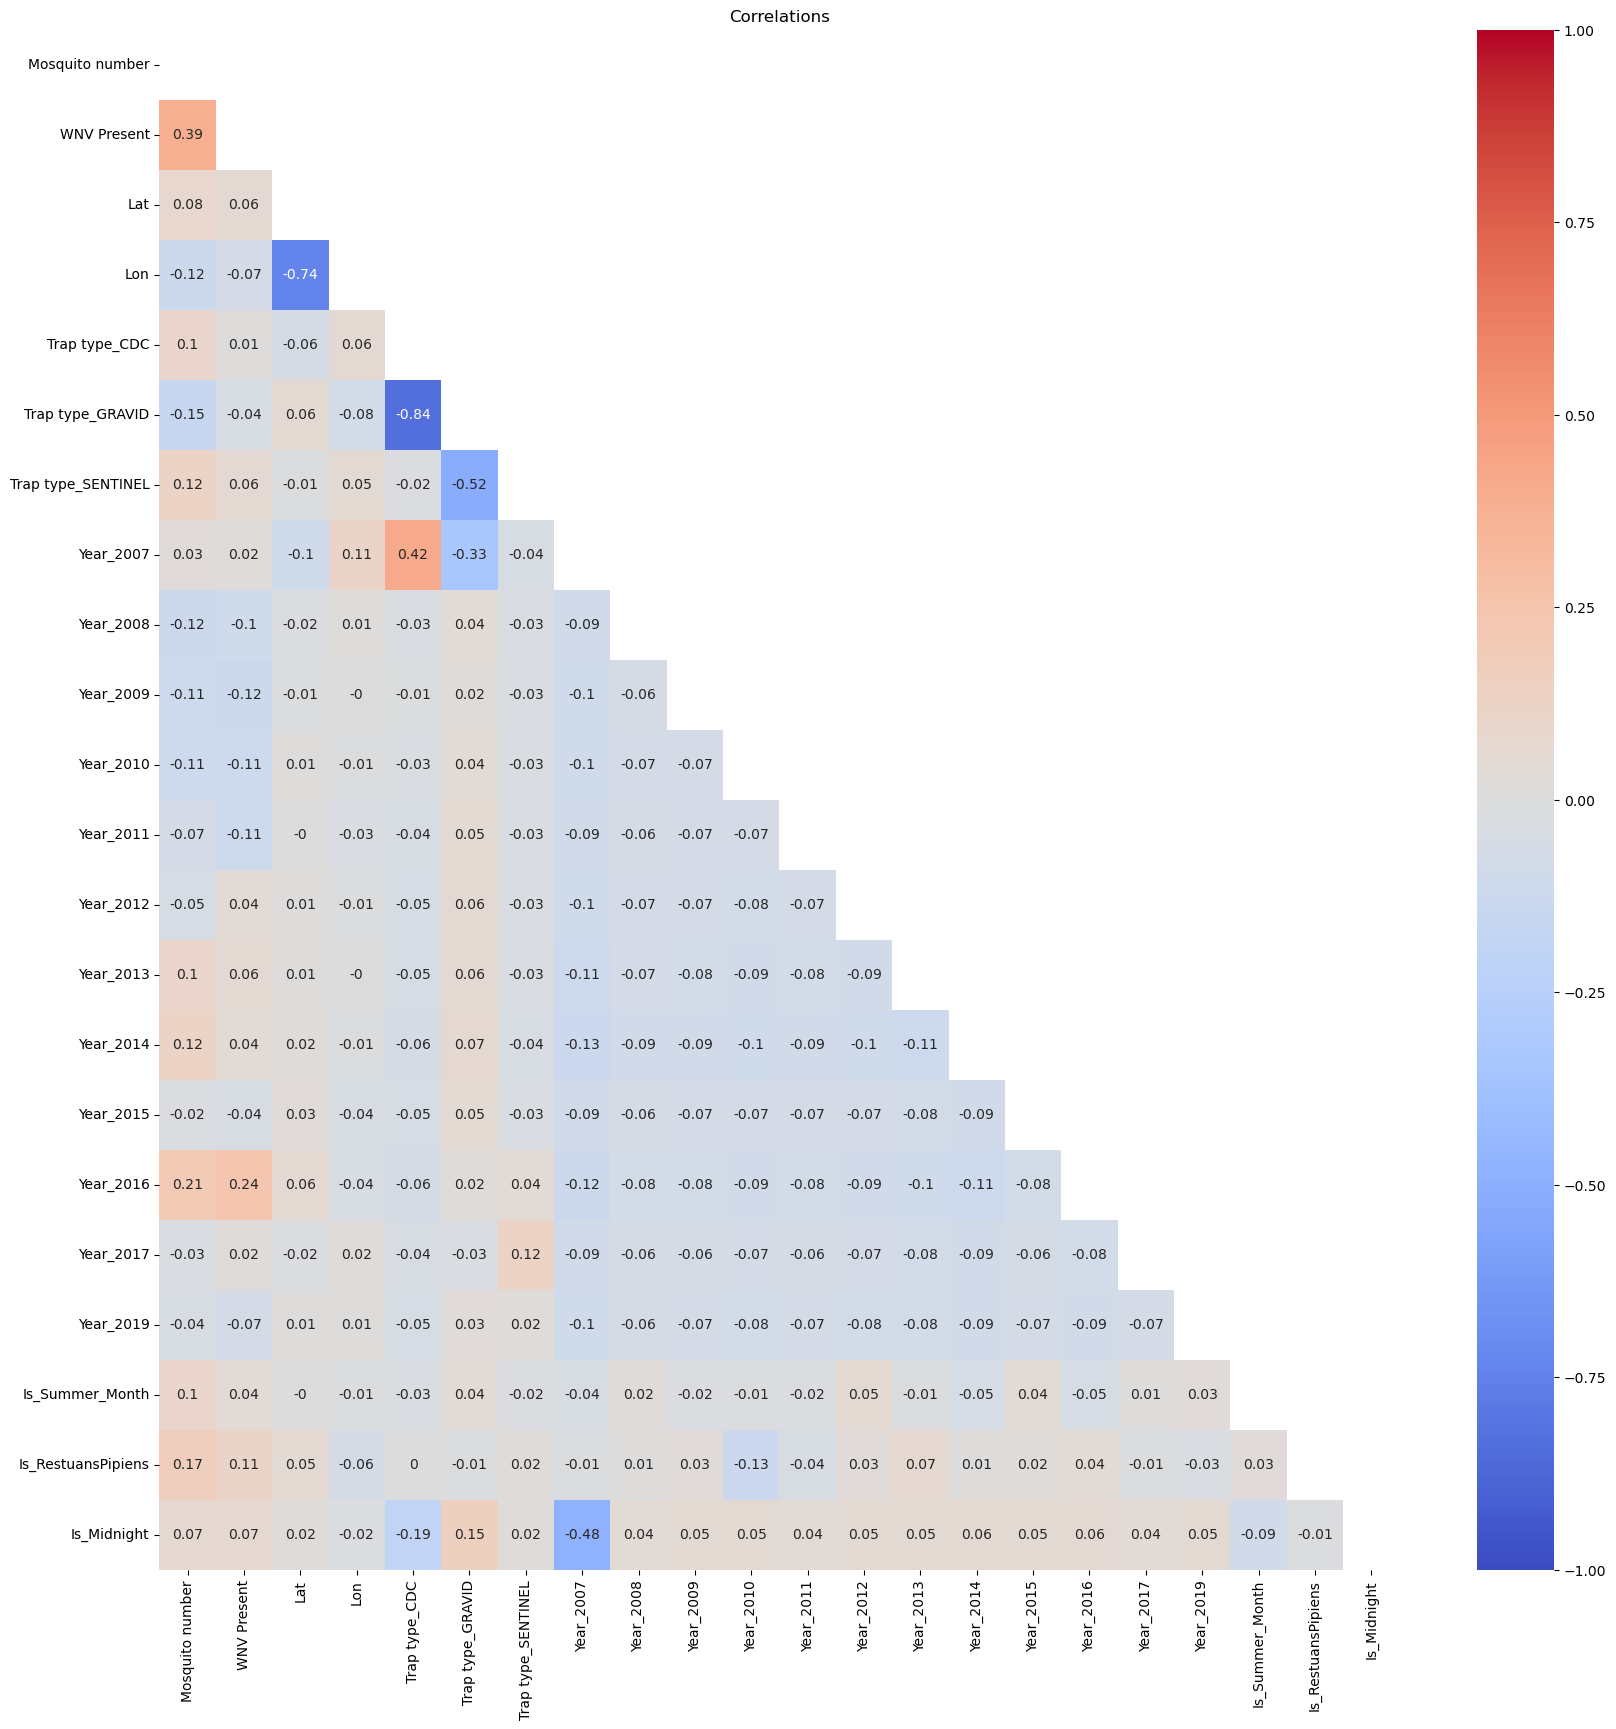

In [59]:
#visualize the correlations

plt.figure(figsize=(20,20))
plt.title('Correlations')
#annot=True means that the numbers will be displayed inside the boxes themselves
sns.heatmap(corrDf2.round(2), mask=mask,annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Columns that are **positively correlated** with the number of mosquitoes caught are:

* `WNV Present`, `Lat`, `Trap type_CDC`, `Trap type_Sentinel`, `Year_2007`, `Year_2013`, `Year_2014`, `Year_2016`, `Is_Summer_Month`, `Is_RestuansPipiens`, and `Is_Midnight`

Highest among these is unsurprisingly `WNV Present`.

Columns that are **negatively correlated** with the number of mosquitoes caught are:

* `Lon`, `Trap type_Gravid`, `Year_2008`, `Year_2009`, `Year_2010`, `Year_2011`, `Year_2012`, `Year_2015`, `Year_2017`, and `Year_2019`

Greatest among these is `Trap type_Gravid`.


**Colinearity between independent variables**
As I suspected, there is a high correlation between two Trap type variables: `Trap type_Gravid` and `Trap type_CDC` (coeff: -0.84). Since it is below 0.9, I leave both of these variables in the dataframe for now. The second highest correlation among independent variable is between `Lat` and `Lon` (coeff: -0.74). This is probably because the surface area of the geo-location of the data is small. I leave them both in the dataframe as well. 

### Are these correlations statistically significant?

We can do a pairwise Pearson's r analysis to see. 

Null hypothesis: Mosquito numbers are independent from the columns in the dataframe.

Alternative hypothesis: Mosquito numbers are not independent from the columns in the dataframe.

In [60]:
df3 = df2.drop(columns = 'Mosquito number') #drop the dependent variable and create a new dataframe

df3.columns #check the columns

Index(['WNV Present', 'Lat', 'Lon', 'Trap type_CDC', 'Trap type_GRAVID',
       'Trap type_SENTINEL', 'Year_2007', 'Year_2008', 'Year_2009',
       'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014',
       'Year_2015', 'Year_2016', 'Year_2017', 'Year_2019', 'Is_Summer_Month',
       'Is_RestuansPipiens', 'Is_Midnight'],
      dtype='object')

In [61]:
#Perform Pearson's r test on pairs of each independent variable and the mosquito numnber with a for loop 

variables = df3.columns 
y = df2['Mosquito number']

for variable in variables:
    X = df3[variable] #assigns a different column to the independent variable X at each turn
    tval,p = stats.pearsonr(X,y)
    print("Test results for " + variable + " and Mosquito Number is T={:4.3f} and p={:4.3f}".format(tval,p))

Test results for WNV Present and Mosquito Number is T=0.390 and p=0.000
Test results for Lat and Mosquito Number is T=0.076 and p=0.000
Test results for Lon and Mosquito Number is T=-0.116 and p=0.000
Test results for Trap type_CDC and Mosquito Number is T=0.100 and p=0.000
Test results for Trap type_GRAVID and Mosquito Number is T=-0.148 and p=0.000
Test results for Trap type_SENTINEL and Mosquito Number is T=0.117 and p=0.000
Test results for Year_2007 and Mosquito Number is T=0.028 and p=0.000
Test results for Year_2008 and Mosquito Number is T=-0.119 and p=0.000
Test results for Year_2009 and Mosquito Number is T=-0.111 and p=0.000
Test results for Year_2010 and Mosquito Number is T=-0.108 and p=0.000
Test results for Year_2011 and Mosquito Number is T=-0.073 and p=0.000
Test results for Year_2012 and Mosquito Number is T=-0.051 and p=0.000
Test results for Year_2013 and Mosquito Number is T=0.099 and p=0.000
Test results for Year_2014 and Mosquito Number is T=0.121 and p=0.000
Tes

**All of the p-values are near zero!**

**Conclusion**: We can reject the null hypothesis and say that, in the population, there is a significant correlation between the columns in the dataframe and the mosquito number with p-values below 0.05.

## Part 3 - Advanced Statistical Analysis

### 1. Run a linear regression to determine how the independent variables affect the number of mosquitoes caught. Explain your model construction process. Analyze the model and the results and discuss the model’s limitations.

I included the `WNV present`column above because the previous question targeted all of the columns. However, the WNV presence is not independent from the mosquito number. We need to exclude it from the independent variable columns.

In [62]:
df4 = df2.drop(columns = 'WNV Present')

df4.columns

Index(['Mosquito number', 'Lat', 'Lon', 'Trap type_CDC', 'Trap type_GRAVID',
       'Trap type_SENTINEL', 'Year_2007', 'Year_2008', 'Year_2009',
       'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014',
       'Year_2015', 'Year_2016', 'Year_2017', 'Year_2019', 'Is_Summer_Month',
       'Is_RestuansPipiens', 'Is_Midnight'],
      dtype='object')

**Checking for Linearity**

Before moving on, we should check whether the relations are linear. However, the subplots with all the columns do not look readable, especially the binary columns. Below, I create scatterplots showing the relationship between latitude and mosquito number, and longitude and mosquito number. 

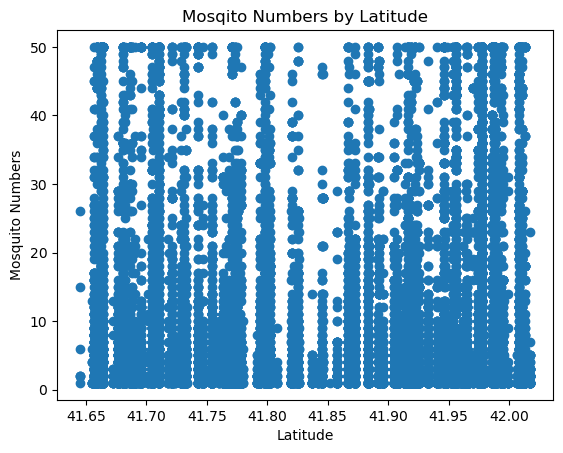

In [63]:
#Check the linearity between Latitude and Mosquito Numbers 
plt.figure()

plt.title('Mosqito Numbers by Latitude')
plt.xlabel('Latitude')
plt.ylabel('Mosquito Numbers')
plt.scatter(df4['Lat'], df4['Mosquito number'])

plt.show()

From the scatter plot, it does not look like there is a linear relationship between the Latitude and Mosquito number.

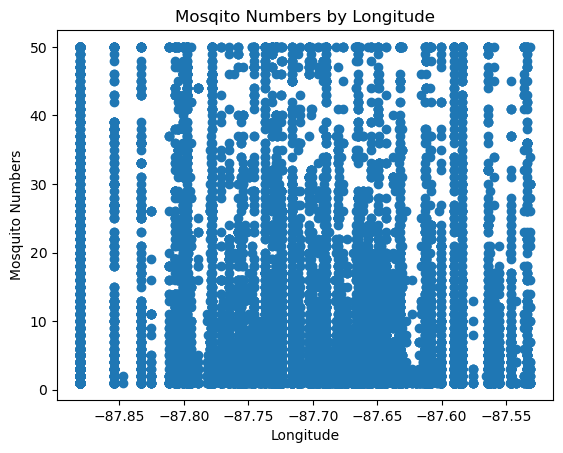

In [64]:
#Check the linearity between Longitude and Mosquito Numbers 
plt.figure()

plt.title('Mosqito Numbers by Longitude')
plt.xlabel('Longitude')
plt.ylabel('Mosquito Numbers')
plt.scatter(df4['Lon'], df4['Mosquito number'])

plt.show()

Neither plot presents a clear linear relationship. With zero expectation, I move on to building a linear regression model nonetheless. 

Null Hypothesis: There is no relationship between the dependent variable, mosquito number, and the independent variables in the dataframe. 

Alternative Hypothesis: There is a significant relationship between the dependent variable, mosquito number, and the independent variables in the dataframe.

### The First Linear Regression Model: lm1

I will follow a backward-selection approach and build the first model with all the variables in it. In later models, I can drop certain independent variables.

In [65]:
X = df4[df4.columns[1:]] #exclude the first column which is the mosquito number
y = df4['Mosquito number']

In [66]:
X_withconstant = sm.add_constant(X) #add the constant
X_withconstant.head()

,const,Lat,Lon,Trap type_CDC,Trap type_GRAVID,Trap type_SENTINEL,Year_2007,Year_2008,Year_2009,Year_2010,...,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2019,Is_Summer_Month,Is_RestuansPipiens,Is_Midnight
0,1.0,41.977738,-87.880969,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
1,1.0,41.798211,-87.736925,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
2,1.0,41.987245,-87.689417,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
3,1.0,41.953664,-87.724987,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
4,1.0,41.657069,-87.546049,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1


In [67]:
lm1 = sm.OLS(y,X_withconstant) #instantiate the model
lm1_results = lm1.fit() #fit the model
lm1_results.summary() #get the results summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     212.6
Date:                Mon, 26 Feb 2024   Prob (F-statistic):               0.00
Time:                        09:23:18   Log-Likelihood:                -69401.
No. Observations:               17837   AIC:                         1.388e+05
Df Residuals:                   17816   BIC:                         1.390e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1686.1863     97.542    -17.287      0.000   -1877.377   -1494.995
Lat                   -4.9102      1.150     -4.270      0.000      -7.164      -2.656
Lon                  -21.3920      1.441    -14.840      0.000     -24.217     -18.567
Trap type_CDC         13.1328     11.872      1.106      0.269     -10.137      36.403
Trap type_GRAVID       4.1829     11.864      0.353      0.724     -19.071      27.437
Trap type_SENTINEL    18.9960     11.894      1.597      0.110      -4.318      42.309
Year_2007              3.7518      0.473      7.931      0.000       2.825       4.679
Year_2008             -5.1748      0.506    -10.222      0.000      -6.167      -4.182
Year_2009             -4.4167      0.489     -9.035      0.000      -5.375      -3.459
Year_2010             -2.7499      0.469     -5.868      0.000      -3.668      -1.831
Year_2011             -1.9777      0.494     -4.005      0.000      -2.946      -1.010
Year_2012             -1.3136      0.468     -2.805      0.005      -2.231      -0.396
Year_2013              5.3986      0.452     11.932      0.000       4.512       6.285
Year_2014              6.2494      0.430     14.517      0.000       5.406       7.093
Year_2015             -0.3738      0.488     -0.766      0.444      -1.331       0.583
Year_2016              9.7020      0.443     21.913      0.000       8.834      10.570
Year_2017             -0.9214      0.497     -1.855      0.064      -1.895       0.052
Year_2019             -0.7750      0.480     -1.614      0.107      -1.716       0.166
Is_Summer_Month        4.4029      0.224     19.625      0.000       3.963       4.843
Is_RestuansPipiens     7.1778      0.369     19.463      0.000       6.455       7.901
Is_Midnight            9.9337      0.601     16.516      0.000       8.755      11.113
==============================================================================
Omnibus:                     4179.348   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8541.669
Skew:                           1.398   Prob(JB):                         0.00
Kurtosis:                       4.916   Cond. No.                     1.07e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Interpretation**

Based on the p-values, we can see that none of the `Trap type` variables seems significant in predicting the mosquito numbers (p-values are > 0.05). Likewise, `Year_2015`, `Year_2017` and `Year 2019` are not significant; again the p-values are > 0.05.

We can try excluding some of these in the next iteration. This might help reduce colinearity and improve our model.

In contrast to these variables, `Longitude` has a near zero p-value and the highest correlation coefficient. With one unit increase in longitude, there is 21.3 decrease in `Mosquito number`. `Longitude` is followed by `Is_Midnight` with a correlation coefficient of 9.9.


**Model Evaluation**

We check the residuals to evaluate our model. They should be normally distributed. We can visualize them on histogram and QQ-Plot to check this for model evaluation.

In [68]:
#get residuals
model_resids = lm1_results.resid 
# Fitted values are the predicted Y for each input row of independent variables.
# These values are also in the results object
model_fittedvals = lm1_results.fittedvalues

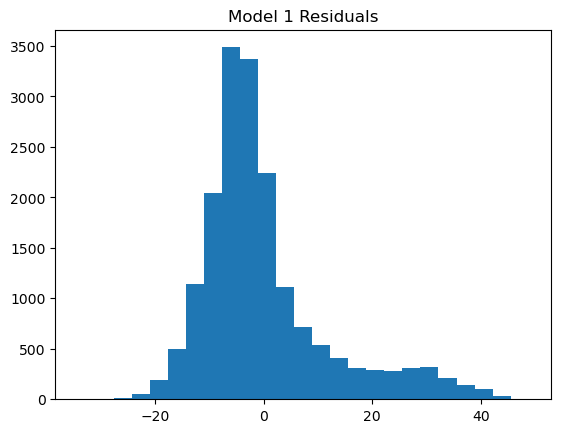

In [69]:
plt.figure()
plt.title('Model 1 Residuals')
plt.hist(model_resids, bins = 25)
plt.show()

The residual distribution is **right skewed**, but this looks promising for getting a normal distribution in the next iteration. 

Next, I create a probability plot to visualize actual residuals vs. what they should be if they were normally distributed.

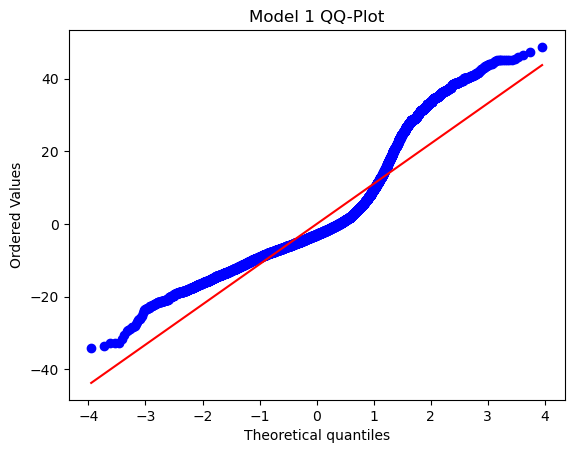

In [70]:
plt.figure()
stats.probplot(model_resids, dist="norm", plot = plt)
plt.title('Model 1 QQ-Plot')
plt.show()

Most points are not on the red line that shows where they should be if they were normally distributed.

Looking at the histogram and the Q-Q Plot above, **the residuals are not normally distributed**. 

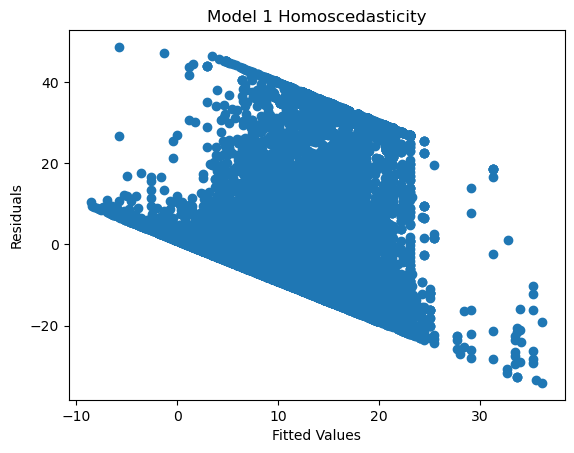

In [71]:
#scatter plot to check homoscedasticity
plt.figure()
plt.title('Model 1 Homoscedasticity')
plt.scatter(lm1_results.fittedvalues, lm1_results.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

This plot should look like random noise because the residual values should be the same regardless of the value of $\hat{Y}$, but it doesn't.

### The Second Linear Regression Model: lm2

In this model, instead of dropping all the columns with a high p-value in the first model, I do the following. I drop the year columns that had high p-values. I also drop the `Trap type_GRAVID` column. It has the lowest coefficient among the trap type columns, aiming to decrease colinearity in the model.

In [72]:
#drop four of the columns with high p-values and low coefficients in the first model
df5 = df4.drop(columns = ['Trap type_GRAVID', 'Year_2015', 'Year_2017', 'Year_2019'])

df5.columns

Index(['Mosquito number', 'Lat', 'Lon', 'Trap type_CDC', 'Trap type_SENTINEL',
       'Year_2007', 'Year_2008', 'Year_2009', 'Year_2010', 'Year_2011',
       'Year_2012', 'Year_2013', 'Year_2014', 'Year_2016', 'Is_Summer_Month',
       'Is_RestuansPipiens', 'Is_Midnight'],
      dtype='object')

In [73]:
X = df5[df5.columns[1:]] #exclude the first column which is the mosquito number
y = df5['Mosquito number']

In [74]:
X_withconstant = sm.add_constant(X) #add the constant
X_withconstant.head()

,const,Lat,Lon,Trap type_CDC,Trap type_SENTINEL,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2016,Is_Summer_Month,Is_RestuansPipiens,Is_Midnight
0,1.0,41.977738,-87.880969,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,1.0,41.798211,-87.736925,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,1.0,41.987245,-87.689417,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1.0,41.953664,-87.724987,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,1.0,41.657069,-87.546049,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [75]:
lm2 = sm.OLS(y,X_withconstant) #instantiate the model
lm2_results = lm2.fit() #fit the model
lm2_results.summary() #get the results summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     265.4
Date:                Mon, 26 Feb 2024   Prob (F-statistic):               0.00
Time:                        09:23:19   Log-Likelihood:                -69403.
No. Observations:               17837   AIC:                         1.388e+05
Df Residuals:                   17820   BIC:                         1.390e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1689.7915     96.640    -17.485      0.000   -1879.216   -1500.367
Lat                   -4.9262      1.149     -4.286      0.000      -7.179      -2.673
Lon                  -21.4821      1.440    -14.917      0.000     -24.305     -18.659
Trap type_CDC          8.9530      0.576     15.546      0.000       7.824      10.082
Trap type_SENTINEL    14.8301      0.837     17.728      0.000      13.190      16.470
Year_2007              4.2558      0.375     11.357      0.000       3.521       4.990
Year_2008             -4.6765      0.418    -11.200      0.000      -5.495      -3.858
Year_2009             -3.9178      0.396     -9.897      0.000      -4.694      -3.142
Year_2010             -2.2492      0.371     -6.069      0.000      -2.976      -1.523
Year_2011             -1.4781      0.402     -3.677      0.000      -2.266      -0.690
Year_2012             -0.8169      0.371     -2.202      0.028      -1.544      -0.090
Year_2013              5.8971      0.350     16.851      0.000       5.211       6.583
Year_2014              6.7496      0.321     21.052      0.000       6.121       7.378
Year_2016             10.2008      0.338     30.152      0.000       9.538      10.864
Is_Summer_Month        4.4279      0.224     19.768      0.000       3.989       4.867
Is_RestuansPipiens     7.1923      0.369     19.516      0.000       6.470       7.915
Is_Midnight            9.9519      0.601     16.558      0.000       8.774      11.130
==============================================================================
Omnibus:                     4186.328   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8568.531
Skew:                           1.400   Prob(JB):                         0.00
Kurtosis:                       4.921   Cond. No.                     1.06e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Interpretation**

Based on the p-values, we can see that all of the independent variables seem significant in predicting the mosquito numbers (p-values are < 0.05). Removing the `Trap Type_Gravid` from the model seems to have improved the colinearity. Now, `Trap type_CDC` and `Trap type_SENTINEL` both have p-values below 0.05.

`Longitude` again has the highest correlation coefficient (in negative). With one unit increase in longitude, there is now 21.5 decrease in `Mosquito number`. Now, the second highest correlation coefficient belongs to `Trap type_SENTINEL` (coef: 14.8).

Next, I visualize the residuals.

**Model Evaluation**

In [76]:
#get residuals
model_resids2 = lm2_results.resid 
# Fitted values are the predicted Y for each input row of independent variables.
# These values are also in the results object
model_fittedvals2 = lm2_results.fittedvalues

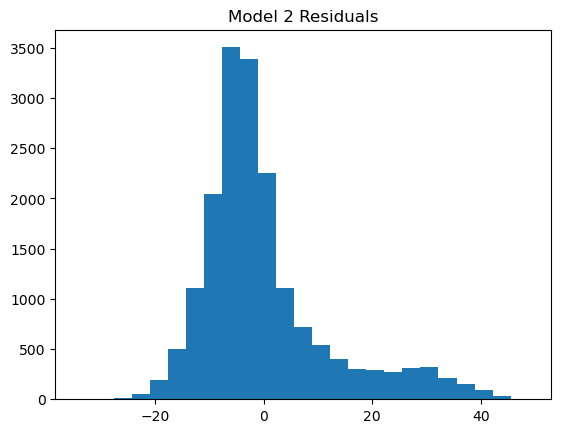

In [77]:
plt.figure()
plt.title('Model 2 Residuals')
plt.hist(model_resids2, bins = 25)
plt.show()

It does not look much different! The distribution is still right skewed.

Let's also do a QQ-Plot!

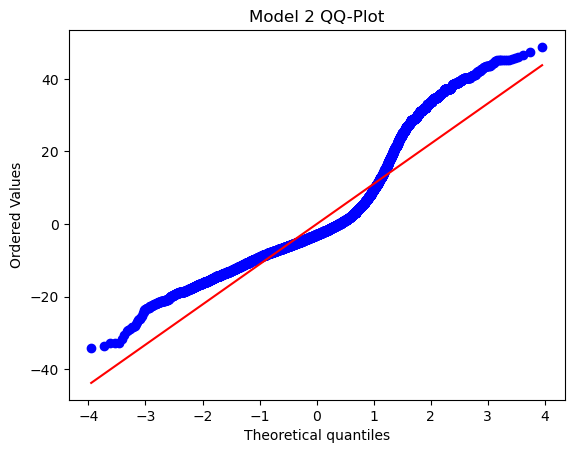

In [78]:
plt.figure()
stats.probplot(model_resids2, dist="norm", plot = plt)
plt.title('Model 2 QQ-Plot')
plt.show()

**This is also not much different!**

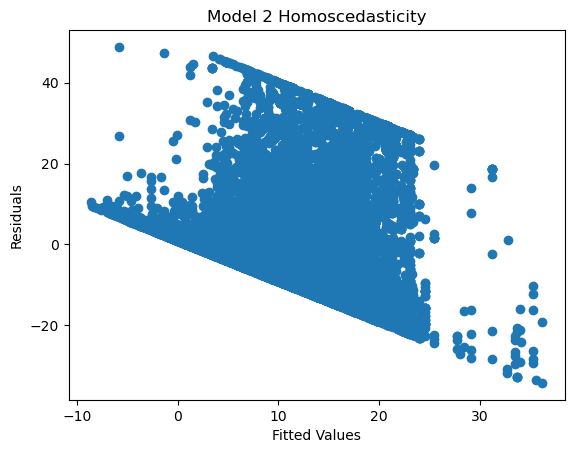

In [79]:
#scatter plot to check homoscedasticity
plt.figure()
plt.title('Model 2 Homoscedasticity')
plt.scatter(lm2_results.fittedvalues, lm2_results.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

This plot doesn't look much different than the previous scatterplot for homoscedasticity either.

### The Third Linear Regression Model: lm3

In this model, I will exclude all the year variables except for `Year_2016` since it has a really high coefficient (10.2). This will leave us with `Lat`, `Lon`, `Is_Summer_Month`, `Is_Midnight`, `Is_RestuansPipiens`, `Trap type_SENTINEL`, and `Trap type_CDC`.

In [80]:
df6 = df5[['Mosquito number', 'Lon', 'Lat', 'Is_Summer_Month', 'Is_RestuansPipiens', 'Is_Midnight', 
           'Trap type_SENTINEL', 'Trap type_CDC', 'Year_2016']]

df6.columns

Index(['Mosquito number', 'Lon', 'Lat', 'Is_Summer_Month',
       'Is_RestuansPipiens', 'Is_Midnight', 'Trap type_SENTINEL',
       'Trap type_CDC', 'Year_2016'],
      dtype='object')

In [81]:
X = df6[df6.columns[1:]] #exclude the first column which is the mosquito number
y = df6['Mosquito number']

In [82]:
X_withconstant = sm.add_constant(X) #add the constant
X_withconstant.head()

,const,Lon,Lat,Is_Summer_Month,Is_RestuansPipiens,Is_Midnight,Trap type_SENTINEL,Trap type_CDC,Year_2016
0,1.0,-87.880969,41.977738,0,1,1,0,0,0
1,1.0,-87.736925,41.798211,0,1,1,0,0,0
2,1.0,-87.689417,41.987245,0,1,1,0,0,0
3,1.0,-87.724987,41.953664,0,1,1,0,0,0
4,1.0,-87.546049,41.657069,0,1,1,0,0,0


In [83]:
lm3 = sm.OLS(y,X_withconstant) #instantiate the model
lm3_results = lm3.fit() #fit the model
lm3_results.summary() #get the results summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     322.4
Date:                Mon, 26 Feb 2024   Prob (F-statistic):               0.00
Time:                        09:23:20   Log-Likelihood:                -70104.
No. Observations:               17837   AIC:                         1.402e+05
Df Residuals:                   17828   BIC:                         1.403e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1539.5946    100.067    -15.386      0.000   -1735.736   -1343.453
Lon                  -19.2881      1.494    -12.912      0.000     -22.216     -16.360
Lat                   -3.8287      1.194     -3.207      0.001      -6.169      -1.488
Is_Summer_Month        3.8409      0.231     16.662      0.000       3.389       4.293
Is_RestuansPipiens     7.9722      0.379     21.050      0.000       7.230       8.715
Is_Midnight            6.8921      0.557     12.365      0.000       5.800       7.985
Trap type_SENTINEL    13.9775      0.861     16.239      0.000      12.290      15.665
Trap type_CDC         10.8117      0.556     19.443      0.000       9.722      11.902
Year_2016              9.2676      0.317     29.266      0.000       8.647       9.888
==============================================================================
Omnibus:                     4613.037   Durbin-Watson:                   1.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9811.485
Skew:                           1.526   Prob(JB):                         0.00
Kurtosis:                       4.970   Cond. No.                     1.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Interpretation**

All of the p-values are below 0.05. `Lon` and `Lat` are negatively correlated with the `Mosquito number` with similar correlation coefficients as before. The other columns are positively correlated and their correlation coefficients changed. For example, `Is_Midnight` now has a correlation coefficient of 6.8, and it was 9.9 in the model before.


**Model Evaluation**

In [84]:
#get residuals
model_resids3 = lm3_results.resid 
# Fitted values are the predicted Y for each input row of independent variables.
# These values are also in the results object
model_fittedvals3 = lm3_results.fittedvalues

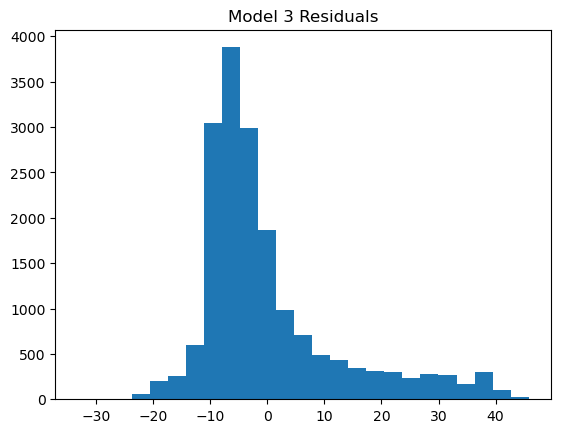

In [85]:
plt.figure()
plt.title('Model 3 Residuals')
plt.hist(model_resids3, bins = 25)
plt.show()

Values in the right skew part of the histogram seems to have decreased a little, but the center is higher. 

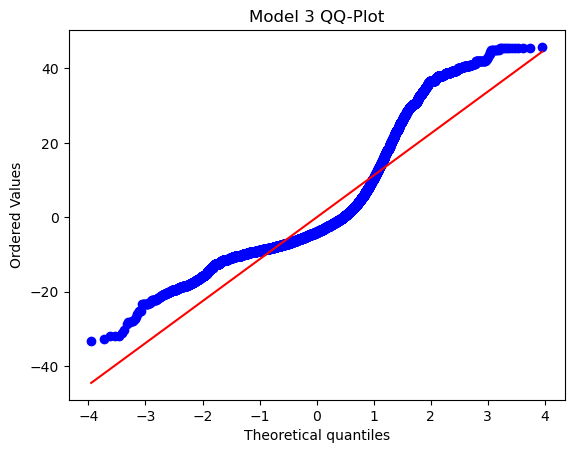

In [86]:
plt.figure()
stats.probplot(model_resids3, dist="norm", plot = plt)
plt.title('Model 3 QQ-Plot')
plt.show()

The points have gone further away from the red line compared to the previous model. 

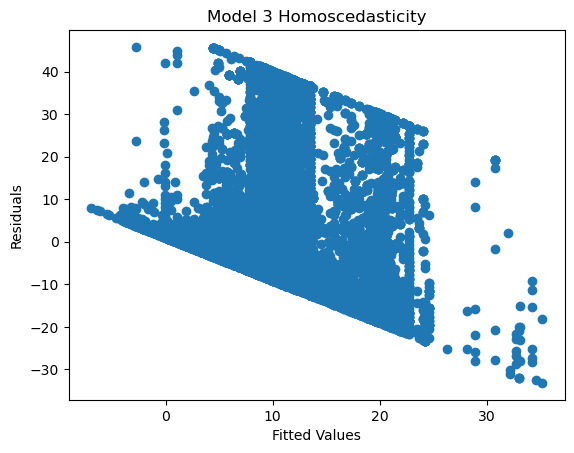

In [87]:
#scatter plot to check homoscedasticity
plt.figure()
plt.title('Model 3 Homoscedasticity')
plt.scatter(lm3_results.fittedvalues, lm3_results.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

The center part of the plot now has less points, but this still doesn't look like random noise.

### The Fourth Linear Regression Model: lm4

In this final model, I will include only the top 3 variables with the highest correlation coefficient: `Lon` (coef: 19.3), `Trap type_CDC` (coef: 10.8), and `Trap type_SENTINEL` (coef: 13.9) from the previous model.

In [88]:
df7 = df5[['Mosquito number', 'Lon', 'Trap type_CDC', 'Trap type_SENTINEL']]

df7.columns

Index(['Mosquito number', 'Lon', 'Trap type_CDC', 'Trap type_SENTINEL'], dtype='object')

In [89]:
X = df7[df7.columns[1:]] #exclude the first column which is the mosquito number
y = df7['Mosquito number']

In [90]:
X_withconstant = sm.add_constant(X) #add the constant
X_withconstant.head()

,const,Lon,Trap type_CDC,Trap type_SENTINEL
0,1.0,-87.880969,0,0
1,1.0,-87.736925,0,0
2,1.0,-87.689417,0,0
3,1.0,-87.724987,0,0
4,1.0,-87.546049,0,0


In [91]:
lm4 = sm.OLS(y,X_withconstant) #instantiate the model
lm4_results = lm4.fit() #fit the model
lm4_results.summary() #get the results summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     250.7
Date:                Mon, 26 Feb 2024   Prob (F-statistic):          2.48e-159
Time:                        09:23:21   Log-Likelihood:                -70941.
No. Observations:               17837   AIC:                         1.419e+05
Df Residuals:                   17833   BIC:                         1.419e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1610.2780     92.608    -17.388      0.000   -1791.799   -1428.757
Lon                  -18.4740      1.056    -17.497      0.000     -20.544     -16.404
Trap type_CDC          8.4969      0.571     14.880      0.000       7.378       9.616
Trap type_SENTINEL    15.3565      0.900     17.062      0.000      13.592      17.121
==============================================================================
Omnibus:                     4903.356   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10569.480
Skew:                           1.629   Prob(JB):                         0.00
Kurtosis:                       4.900   Cond. No.                     8.40e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Interpretation**

The effects of `Longitude` and `Trap type_CDC` have decreased one unit each while that of `Trap type_SENTINEL` has increased around 1.5.

Let's see if the residuals have changed a lot.

**Model Evaluation**

In [92]:
#get residuals
model_resids4 = lm4_results.resid 
# Fitted values are the predicted Y for each input row of independent variables.
# These values are also in the results object
model_fittedvals4 = lm4_results.fittedvalues

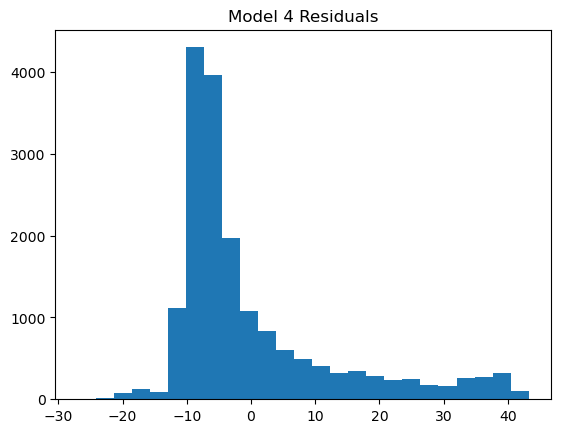

In [93]:
plt.figure()
plt.title('Model 4 Residuals')
plt.hist(model_resids4, bins = 25)
plt.show()

The center peak is higher and the right skew is more pronounced.

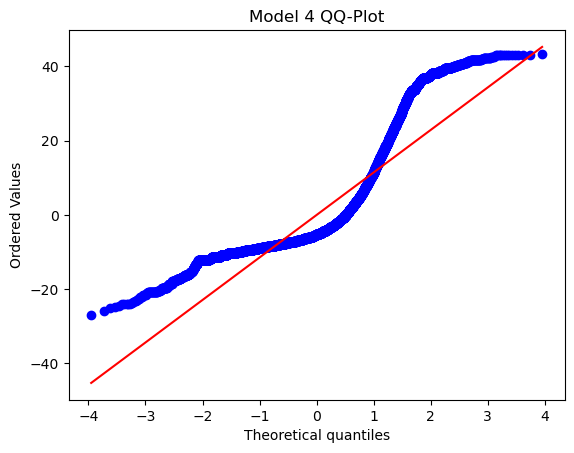

In [94]:
plt.figure()
stats.probplot(model_resids4, dist="norm", plot = plt)
plt.title('Model 4 QQ-Plot')
plt.show()

Points got farther away from the red line. The distribution of the residuals is less normal-like than it was before.

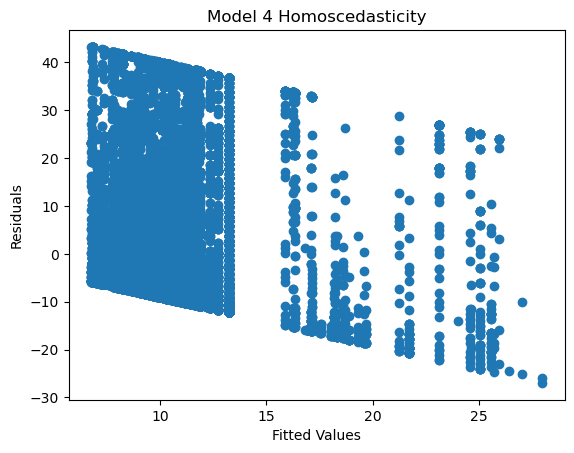

In [95]:
#scatter plot to check homoscedasticity
plt.figure()
plt.title('Model 4 Homoscedasticity')
plt.scatter(lm4_results.fittedvalues, lm4_results.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

This looks much different than before but still not like random noise.

Overall, the plots for evaluating the model show that this model present actaully a worse picture than the previous ones.

**CONCLUSION** 

None of the linear regression models above pass the tests for the assumptions of linear regression models. 

We fail to reject the null hypothesis that there is no relationship between the dependent variable, mosquito number, and the independent variables in the dataframe.

### 2. Run a logistic regression to determine how the independent variables affect West Nile Virus presence. Explain your model construction process. Analyze the model and the results and discuss the model's limitations.

As we saw earlier, `WNV Present` and `Mosquito number` are highly correlated. I will not change the way other independent variable columns are encoded in the data. 

We can check the correlations between the `WNV Present` column and the other columns ensure that this is fine.

### Correlations

In [96]:
df2.info() #sanity check on the dataframe we use

<class 'pandas.core.frame.DataFrame'>
Index: 17837 entries, 0 to 18493
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Mosquito number     17837 non-null  int64  
 1   WNV Present         17837 non-null  int64  
 2   Lat                 17837 non-null  float64
 3   Lon                 17837 non-null  float64
 4   Trap type_CDC       17837 non-null  uint8  
 5   Trap type_GRAVID    17837 non-null  uint8  
 6   Trap type_SENTINEL  17837 non-null  uint8  
 7   Year_2007           17837 non-null  uint8  
 8   Year_2008           17837 non-null  uint8  
 9   Year_2009           17837 non-null  uint8  
 10  Year_2010           17837 non-null  uint8  
 11  Year_2011           17837 non-null  uint8  
 12  Year_2012           17837 non-null  uint8  
 13  Year_2013           17837 non-null  uint8  
 14  Year_2014           17837 non-null  uint8  
 15  Year_2015           17837 non-null  uint8  
 16  Year_2016

In [97]:
#make the WNV Present the first column
df2.insert(0, 'WNV Present', df2.pop('WNV Present'))
df2.columns

Index(['WNV Present', 'Mosquito number', 'Lat', 'Lon', 'Trap type_CDC',
       'Trap type_GRAVID', 'Trap type_SENTINEL', 'Year_2007', 'Year_2008',
       'Year_2009', 'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013',
       'Year_2014', 'Year_2015', 'Year_2016', 'Year_2017', 'Year_2019',
       'Is_Summer_Month', 'Is_RestuansPipiens', 'Is_Midnight'],
      dtype='object')

In [98]:
corrDf = df2.corr() #this will not be readable

In [99]:
mask = np.triu(corrDf) #triu = upper triangle, mask will help readability

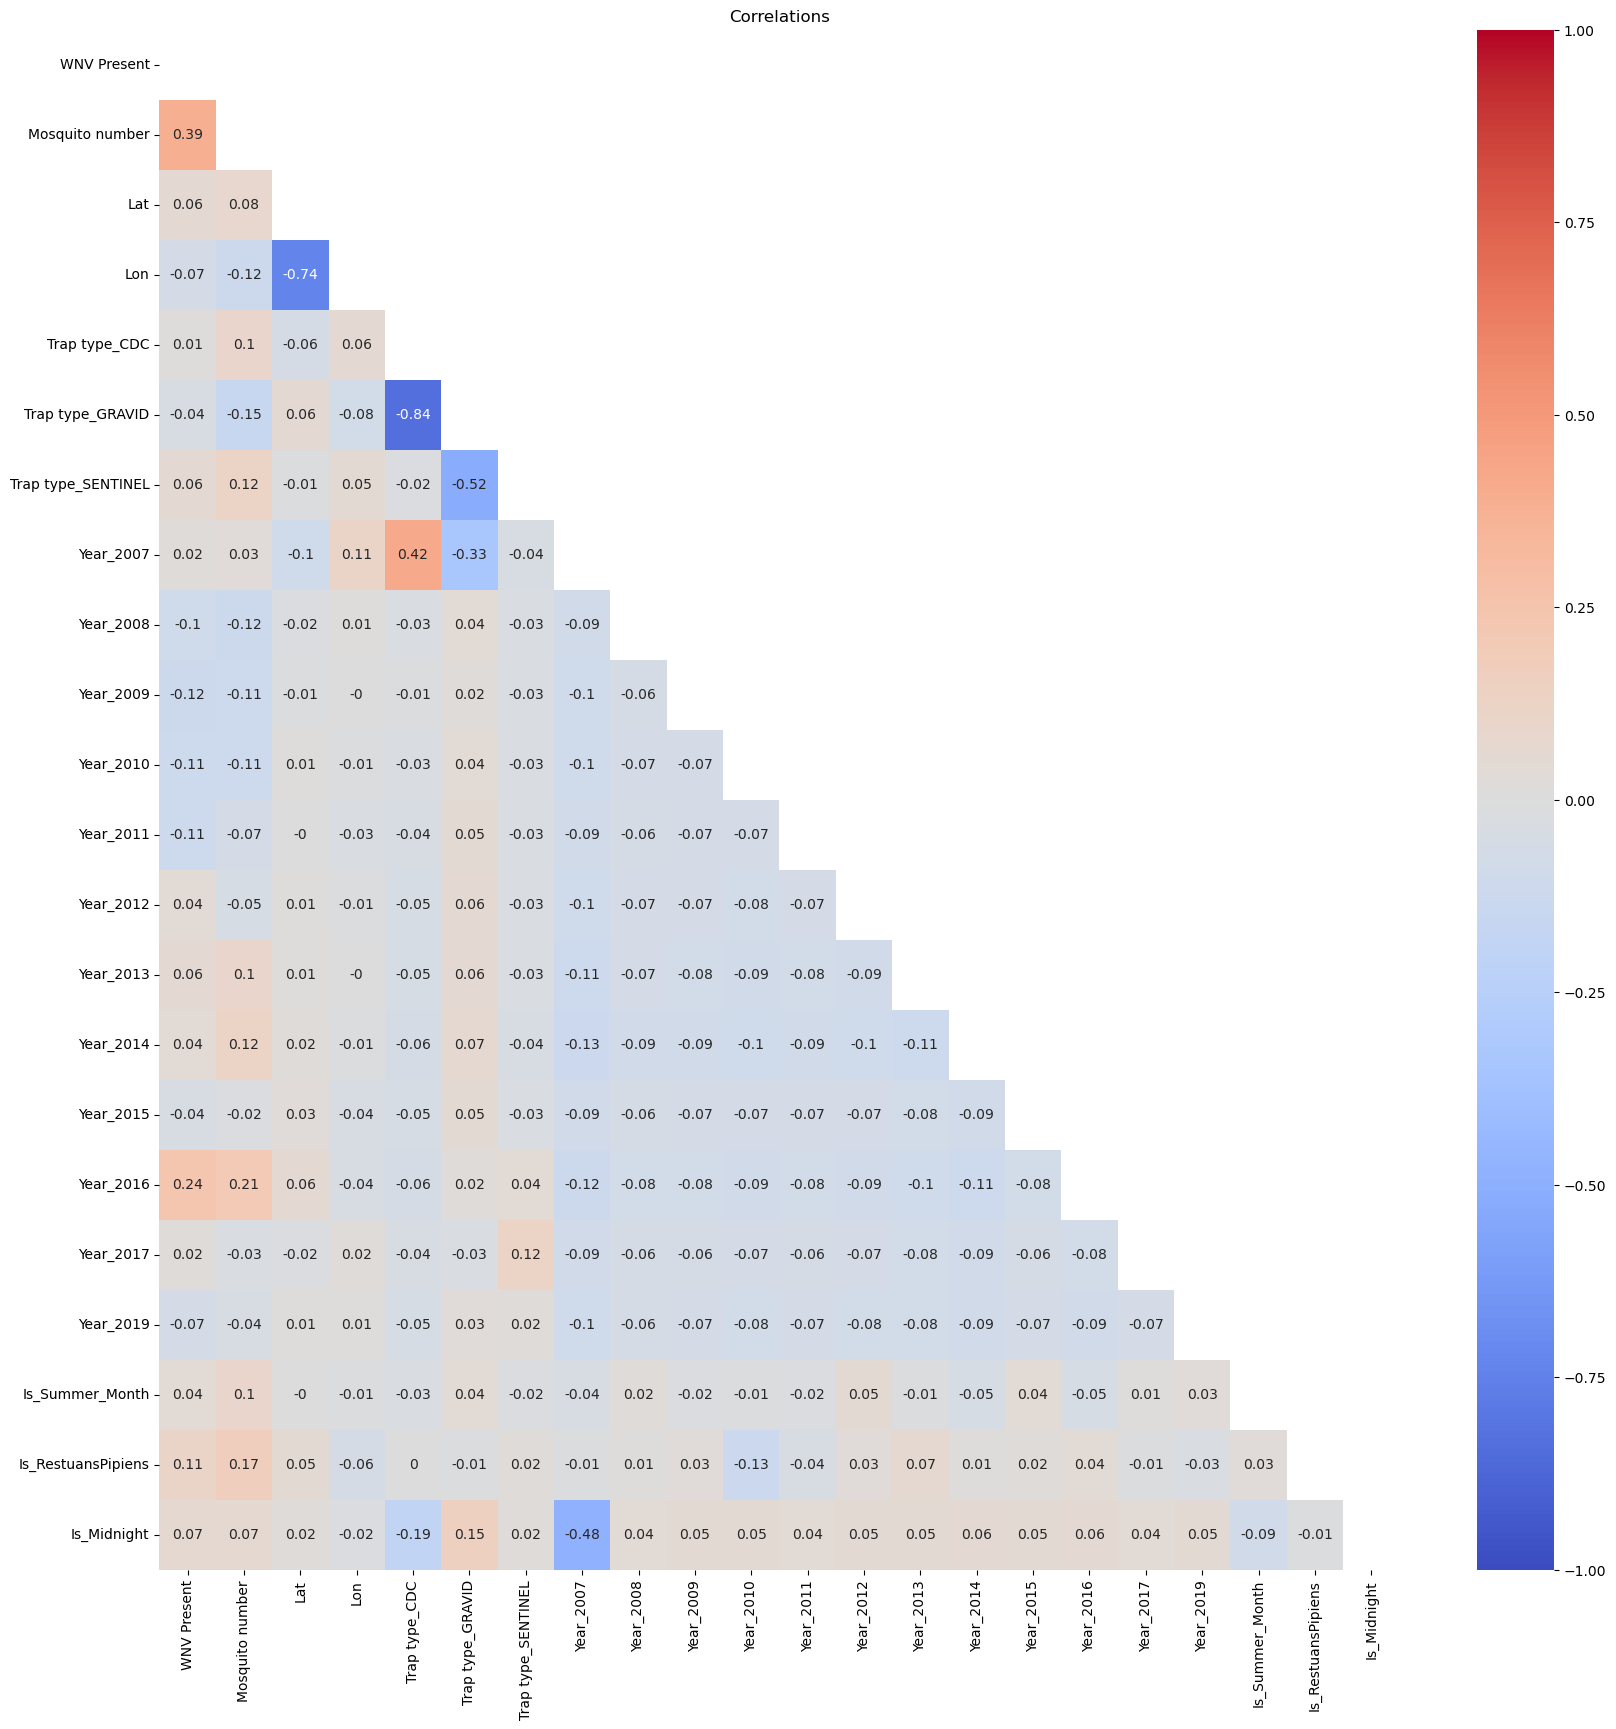

In [100]:
#visualize the correlations

plt.figure(figsize=(20,20))
plt.title('Correlations')
#annot=True means that the numbers will be displayed inside the boxes themselves
sns.heatmap(corrDf.round(2), mask=mask,annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

**Colinearities** are the same as before; they are all below 0.85. 

None of the independent columns have 0 correlation with `WNV Present`. We can keep the Dataframe as it is. 

Columns that are **positively correlated** with `WNV Present` are:

* `Mosquito number`, `Lat`, `Trap type_CDC`, `Trap type_SENTINEL`, `Year_2007`, `Year_2012`, `Year_2013`, `Year_2014`, `Year_2016`, `Year_2017`, `Is_Summer_Month`, `Is_RestuansPipiens`, and `Is_Midnight`

Highest among these is unsurprisingly `Mosquito number` (coef: 0.39).

Columns that are **negatively correlated** with `WNV Present` are:

* `Lon`, `Trap type_Gravid`, `Year_2008`, `Year_2009`, `Year_2010`, `Year_2011`, `Year_2015`, and `Year_2019`

Greatest among these is `Year_2009` (coef: 0.12).

Null hypothesis: WNV presence is independent from the columns in the dataframe.

Alternative hypothesis: WNV presence is not independent from the columns in the dataframe.

Let's run a Pearson's r test to see if these correlations are significant. (This is an extra step that I am doing)

In [101]:
df8 = df2.drop(columns = ['WNV Present']) #drop the dependent variable
df8.columns

Index(['Mosquito number', 'Lat', 'Lon', 'Trap type_CDC', 'Trap type_GRAVID',
       'Trap type_SENTINEL', 'Year_2007', 'Year_2008', 'Year_2009',
       'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014',
       'Year_2015', 'Year_2016', 'Year_2017', 'Year_2019', 'Is_Summer_Month',
       'Is_RestuansPipiens', 'Is_Midnight'],
      dtype='object')

In [102]:
#Perform Pearson's r test on pairs of each independent variable and the mosquito numnber with a for loop 
variables = df8.columns 
y = df2['WNV Present']

for variable in variables:
    X = df8[variable] #assigns a different column to the independent variable X at each turn
    tval,p = stats.pearsonr(X,y)
    print("Test results for " + variable + " and WNV Present is T={:4.3f} and p={:4.3f}".format(tval,p))

Test results for Mosquito number and WNV Present is T=0.390 and p=0.000
Test results for Lat and WNV Present is T=0.055 and p=0.000
Test results for Lon and WNV Present is T=-0.067 and p=0.000
Test results for Trap type_CDC and WNV Present is T=0.006 and p=0.424
Test results for Trap type_GRAVID and WNV Present is T=-0.037 and p=0.000
Test results for Trap type_SENTINEL and WNV Present is T=0.059 and p=0.000
Test results for Year_2007 and WNV Present is T=0.021 and p=0.006
Test results for Year_2008 and WNV Present is T=-0.103 and p=0.000
Test results for Year_2009 and WNV Present is T=-0.116 and p=0.000
Test results for Year_2010 and WNV Present is T=-0.110 and p=0.000
Test results for Year_2011 and WNV Present is T=-0.111 and p=0.000
Test results for Year_2012 and WNV Present is T=0.037 and p=0.000
Test results for Year_2013 and WNV Present is T=0.065 and p=0.000
Test results for Year_2014 and WNV Present is T=0.036 and p=0.000
Test results for Year_2015 and WNV Present is T=-0.044 a

All the p-values are below 0.05 except for. `Trap type_CDC`. Let's keep this in mind and move on to building the first model.

### The First Logistic Regression Model: LR1

I will follow a backward-selection approach and build the first model with all the variables in it. In later models, I can drop certain independent variables.

In [103]:
X = df2[df2.columns[1:]]
y = df2['WNV Present']

In [104]:
X_withC = sm.add_constant(X) #add the constant
X_withC.head()

,const,Mosquito number,Lat,Lon,Trap type_CDC,Trap type_GRAVID,Trap type_SENTINEL,Year_2007,Year_2008,Year_2009,...,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2019,Is_Summer_Month,Is_RestuansPipiens,Is_Midnight
0,1.0,2,41.977738,-87.880969,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
1,1.0,1,41.798211,-87.736925,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
2,1.0,2,41.987245,-87.689417,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
3,1.0,1,41.953664,-87.724987,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
4,1.0,9,41.657069,-87.546049,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1


**Detecting Colinearity with VIF**

The instructions say this is not required but I was curious. VIF scores for the Trap types are really very high but we will keep them in the initial model.

In [105]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

for i, col in enumerate(X_withC):
    print(f'VIF for {col} is: {variance_inflation_factor(X_withC, i)}')
    print('\n') #prints a blank new line between each output

VIF for const is: 1228470.6127206364


VIF for Mosquito number is: 1.2386377050710884


VIF for Lat is: 2.215813911229505


VIF for Lon is: 2.253854976942306


VIF for Trap type_CDC is: 515.09671058819


VIF for Trap type_GRAVID is: 709.8353495760887


VIF for Trap type_SENTINEL is: 208.05964509768646


VIF for Year_2007 is: 2.969108555308048


VIF for Year_2008 is: 1.706394593964253


VIF for Year_2009 is: 1.807289728031695


VIF for Year_2010 is: 1.9519289838039877


VIF for Year_2011 is: 1.7705954543371607


VIF for Year_2012 is: 1.913027920473071


VIF for Year_2013 is: 2.090178527174449


VIF for Year_2014 is: 2.3602749903788056


VIF for Year_2015 is: 1.782396419406111


VIF for Year_2016 is: 2.2018024441784307


VIF for Year_2017 is: 1.7146996659376488


VIF for Year_2019 is: 1.8157188382517637


VIF for Is_Summer_Month is: 1.0610336068512083


VIF for Is_RestuansPipiens is: 1.0544115689561424


VIF for Is_Midnight is: 1.3397768995935224




In [106]:
LR1_bfs = sm.Logit(y, X_withC) #instantiate


LR1_bfs_results = LR1_bfs.fit() #fit


LR1_bfs_results.summary() #summary

         Current function value: 0.370783
         Iterations: 35


/Users/duygu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                17837
Model:                          Logit   Df Residuals:                    17815
Method:                           MLE   Df Model:                           21
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                  0.2306
Time:                        09:23:23   Log-Likelihood:                -6613.7
converged:                      False   LL-Null:                       -8595.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -120.8480   2793.653     -0.043      0.965   -5596.307    5354.611
Mosquito number        0.0494      0.002     32.154      0.000       0.046       0.052
Lat                    0.0020      0.294      0.007      0.994      -0.573       0.577
Lon                   -1.1712      0.366     -3.199      0.001      -1.889      -0.454
Trap type_CDC         11.4924   2793.546      0.004      0.997   -5463.758    5486.742
Trap type_GRAVID      12.1145   2793.546      0.004      0.997   -5463.135    5487.364
Trap type_SENTINEL    12.0971   2793.546      0.004      0.997   -5463.153    5487.347
Year_2007              0.0303      0.098      0.308      0.758      -0.163       0.223
Year_2008             -2.5062      0.232    -10.801      0.000      -2.961      -2.051
Year_2009             -3.1759      0.279    -11.386      0.000      -3.723      -2.629
Year_2010             -2.0246      0.163    -12.383      0.000      -2.345      -1.704
Year_2011             -2.9928      0.244    -12.246      0.000      -3.472      -2.514
Year_2012             -0.0798      0.096     -0.831      0.406      -0.268       0.108
Year_2013             -0.2869      0.093     -3.094      0.002      -0.469      -0.105
Year_2014             -0.5352      0.091     -5.888      0.000      -0.713      -0.357
Year_2015             -1.0707      0.118     -9.085      0.000      -1.302      -0.840
Year_2016              0.5270      0.088      6.016      0.000       0.355       0.699
Year_2017             -0.2320      0.105     -2.206      0.027      -0.438      -0.026
Year_2019             -1.3650      0.128    -10.664      0.000      -1.616      -1.114
Is_Summer_Month        0.2037      0.058      3.501      0.000       0.090       0.318
Is_RestuansPipiens     1.8220      0.225      8.115      0.000       1.382       2.262
Is_Midnight            2.4097      0.283      8.528      0.000       1.856       2.963
======================================================================================
"""

**Model Interpretation**

The p-values for the constant, trap types, Year_2007, Year_2012 are above 0.05. There appears to be a warning that the model convergence failed. I will not visualize the odds ratios for this model.

**Model Accuracy**

In [107]:
probpreds = LR1_bfs_results.predict(X_withC)  #get the probability predictions

classpreds = np.where(probpreds>0.5, 1, 0) #set the threshold at 0.5

(classpreds == y).sum() #gives the number of rows that were predicted correctly

acc = (classpreds == y).sum() / len(y) #calculate the accuracy

print(acc)

0.8301283848180748


Model didn't converge but the accuracy is at 83%. Let's compare it to the baseline!

In [108]:
df2['WNV Present'].value_counts(normalize=True)

WNV Present
0    0.812973
1    0.187027
Name: proportion, dtype: float64

The baseline model is 81% if we guess just 0 every time. 

This means **the first model improved upon the baseline by 2%** 

I will not look at accuracy at different thresholds since the model did not converge. Let's build another model!

### The Second Logistic Regression Model: LR2

Let's now remove all of the variables that have a non significant p-value according to the first model (except for the constant).

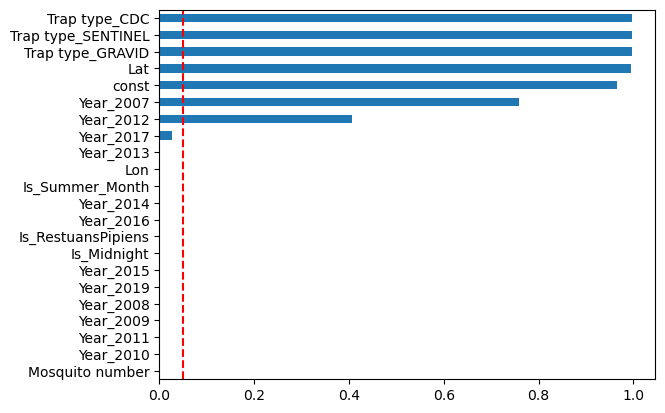

In [109]:
LR1_bfs_results.pvalues.sort_values(ascending=True).plot(kind='barh')
plt.axvline(0.05, color='red', linestyle='--')
plt.show()

In [110]:
#find the names of the variables by sorting by pvalue and only looking at the index (name of variable)

LR1_bfs_results.pvalues.sort_values(ascending=False).index

Index(['Trap type_CDC', 'Trap type_SENTINEL', 'Trap type_GRAVID', 'Lat',
       'const', 'Year_2007', 'Year_2012', 'Year_2017', 'Year_2013', 'Lon',
       'Is_Summer_Month', 'Year_2014', 'Year_2016', 'Is_RestuansPipiens',
       'Is_Midnight', 'Year_2015', 'Year_2019', 'Year_2008', 'Year_2009',
       'Year_2011', 'Year_2010', 'Mosquito number'],
      dtype='object')

In [111]:
#these are now all of the variables from the first model that had significant Pvalues
newX = X[['Year_2017', 'Year_2013', 'Lon',
       'Is_Summer_Month', 'Year_2014', 'Year_2016', 'Is_RestuansPipiens',
       'Is_Midnight', 'Year_2015', 'Year_2019', 'Year_2008', 'Year_2009',
       'Year_2011', 'Year_2010', 'Mosquito number']]

In [112]:
newX_withC = sm.add_constant(newX)

newX_withC.head()

,const,Year_2017,Year_2013,Lon,Is_Summer_Month,Year_2014,Year_2016,Is_RestuansPipiens,Is_Midnight,Year_2015,Year_2019,Year_2008,Year_2009,Year_2011,Year_2010,Mosquito number
0,1.0,0,0,-87.880969,0,0,0,1,1,0,1,0,0,0,0,2
1,1.0,0,0,-87.736925,0,0,0,1,1,0,1,0,0,0,0,1
2,1.0,0,0,-87.689417,0,0,0,1,1,0,1,0,0,0,0,2
3,1.0,0,0,-87.724987,0,0,0,1,1,0,1,0,0,0,0,1
4,1.0,0,0,-87.546049,0,0,0,1,1,0,1,0,0,0,0,9


In [113]:
LR2_bfs = sm.Logit(y, newX_withC) #instantiate

LR2_bfs_results = LR2_bfs.fit() #fit

LR2_bfs_results.summary() #summary

Optimization terminated successfully.
         Current function value: 0.371354
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                17837
Model:                          Logit   Df Residuals:                    17821
Method:                           MLE   Df Model:                           15
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                  0.2294
Time:                        09:23:24   Log-Likelihood:                -6623.8
converged:                       True   LL-Null:                       -8595.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -120.7153     21.001     -5.748      0.000    -161.877     -79.554
Year_2017             -0.1663      0.089     -1.871      0.061      -0.340       0.008
Year_2013             -0.2135      0.072     -2.965      0.003      -0.355      -0.072
Lon                   -1.3077      0.239     -5.460      0.000      -1.777      -0.838
Is_Summer_Month        0.2247      0.057      3.923      0.000       0.112       0.337
Year_2014             -0.4578      0.070     -6.586      0.000      -0.594      -0.322
Year_2016              0.6027      0.066      9.168      0.000       0.474       0.732
Is_RestuansPipiens     1.8157      0.224      8.094      0.000       1.376       2.255
Is_Midnight            2.4368      0.277      8.785      0.000       1.893       2.980
Year_2015             -1.0060      0.103     -9.724      0.000      -1.209      -0.803
Year_2019             -1.2982      0.115    -11.303      0.000      -1.523      -1.073
Year_2008             -2.4532      0.225    -10.902      0.000      -2.894      -2.012
Year_2009             -3.1262      0.273    -11.450      0.000      -3.661      -2.591
Year_2011             -2.9257      0.238    -12.314      0.000      -3.391      -2.460
Year_2010             -1.9667      0.153    -12.828      0.000      -2.267      -1.666
Mosquito number        0.0481      0.001     32.682      0.000       0.045       0.051
======================================================================================
"""

**Model Interpretation**

The convergence was successful. Our constant has a p-value below 0.05. The only predictor with a p-value above 0.05 is `Year_2017`. Let's check the odds ratios!

In [114]:
np.exp(LR2_bfs_results.params) #get the odds ratios by exponentiating the coefficients

const                 3.749669e-53
Year_2017             8.468085e-01
Year_2013             8.077772e-01
Lon                   2.704364e-01
Is_Summer_Month       1.252007e+00
Year_2014             6.326934e-01
Year_2016             1.827042e+00
Is_RestuansPipiens    6.145109e+00
Is_Midnight           1.143647e+01
Year_2015             3.656631e-01
Year_2019             2.730109e-01
Year_2008             8.601419e-02
Year_2009             4.388251e-02
Year_2011             5.362738e-02
Year_2010             1.399164e-01
Mosquito number       1.049313e+00
dtype: float64

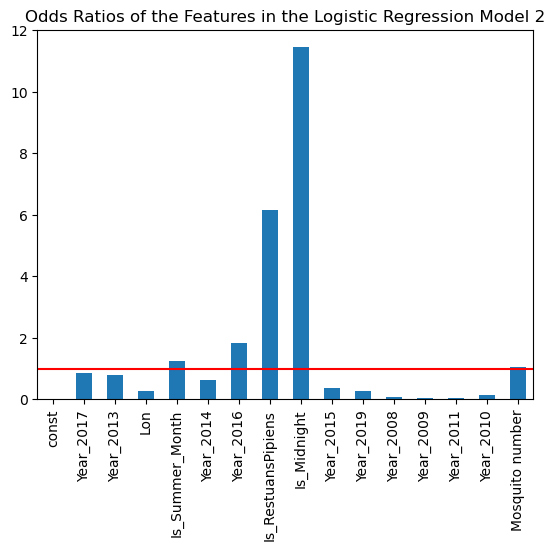

In [115]:
#visualize the exponentiated coefficients
plt.figure()
np.exp(LR2_bfs_results.params).plot(kind='bar')
plt.title('Odds Ratios of the Features in the Logistic Regression Model 2')
plt.axhline(1, color='red')
plt.show()

The features `Is_Summer_Month`, `Year_2016`, `Is_RestuansPipians`, `Is_Midnight`, and `Mosquito number` are positively correlated with the WNV presence while the years and longitude are negatively correlated. For example, if the mosquito belongs to the Restuans or Pipiens Species, the chances of WNV presence increases by a factor of 6.1. On the other hand, as the Longitude increases 1 unit, chances of WNV presence decrease by a factor of 0.27.

**Model Accuracy**

In [116]:
probpreds2 = LR2_bfs_results.predict(newX_withC)  #get the probability predictions

classpreds2 = np.where(probpreds2>0.5, 1, 0) #set the threshold at 0.5

(classpreds2 == y).sum() #gives the number of rows that were predicted correctly

acc2 = (classpreds2 == y).sum() / len(y) #calculate the accuracy

print(acc2)

0.8306329539720805


In [117]:
df2['WNV Present'].value_counts(normalize = True) #baseline is 81%, this shows the class imbalance

WNV Present
0    0.812973
1    0.187027
Name: proportion, dtype: float64

**Model accuracy is again 83%.** This is the same as the first model. We could not improve the model that contained all of the features. Let's check if changing the threshold improves the accuracy. The data is imbalanced for WNV Presence so it makes sense that that the threshold might not be ideal at 0.5.

In [118]:
accuracies = []

THvals = np.arange(0.01, 0.99, 0.01)

for TH in THvals:
    classpreds2 = np.where(probpreds2>TH, 1, 0)
    accuracy = ((classpreds2 == y).sum()) / len(y)
    accuracies.append(accuracy)

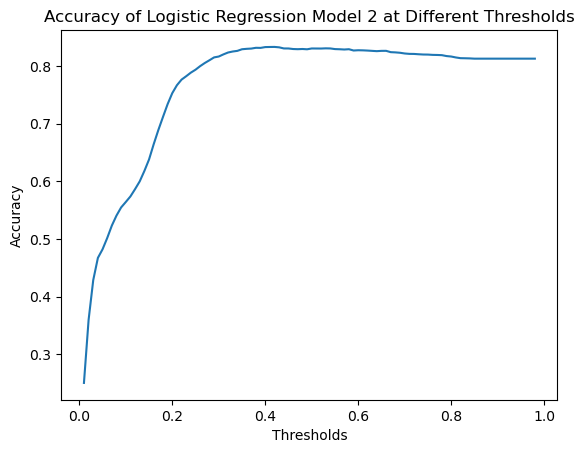

In [119]:
plt.figure()
plt.plot(THvals, accuracies)
plt.title('Accuracy of Logistic Regression Model 2 at Different Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
plt.show()

**Conclusion** Due to the large class imbalance, the model is not performing much better than the baseline at different threshold values. Let's try another model, but it probably will not be much better.

### The Third Logistic Regression Model

For the third model, I will select the top 5 significant features.

In [120]:
LR2_bfs_results.pvalues.sort_values().index #sort the columns based on p-values

Index(['Mosquito number', 'Year_2010', 'Year_2011', 'Year_2009', 'Year_2019',
       'Year_2008', 'Year_2015', 'Year_2016', 'Is_Midnight',
       'Is_RestuansPipiens', 'Year_2014', 'const', 'Lon', 'Is_Summer_Month',
       'Year_2013', 'Year_2017'],
      dtype='object')

In [121]:
newX_withC2 = newX[['Mosquito number', 'Year_2010', 'Year_2011', 'Year_2009', 'Year_2019']] #select columns

newX_withC2 = sm.add_constant(newX_withC2) #add the constant

newX_withC2.head()

,const,Mosquito number,Year_2010,Year_2011,Year_2009,Year_2019
0,1.0,2,0,0,0,1
1,1.0,1,0,0,0,1
2,1.0,2,0,0,0,1
3,1.0,1,0,0,0,1
4,1.0,9,0,0,0,1


In [122]:
LR3_bfs = sm.Logit(y, newX_withC2) #instantiate

LR3_bfs_results = LR3_bfs.fit() #fit

LR3_bfs_results.summary() #get summary

Optimization terminated successfully.
         Current function value: 0.394779
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                17837
Model:                          Logit   Df Residuals:                    17831
Method:                           MLE   Df Model:                            5
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                  0.1808
Time:                        09:23:25   Log-Likelihood:                -7041.7
converged:                       True   LL-Null:                       -8595.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.9606      0.031    -63.290      0.000      -2.021      -1.900
Mosquito number     0.0571      0.001     41.144      0.000       0.054       0.060
Year_2010          -1.7902      0.150    -11.921      0.000      -2.085      -1.496
Year_2011          -2.6969      0.236    -11.451      0.000      -3.158      -2.235
Year_2009          -2.8438      0.272    -10.462      0.000      -3.377      -2.311
Year_2019          -1.0759      0.111     -9.700      0.000      -1.293      -0.859
===================================================================================
"""

**Model Accuracy**

All the features and the constant have p-values near 0. Let's check the odds ratios!

In [123]:
np.exp(LR3_bfs_results.params)

const              0.140777
Mosquito number    1.058776
Year_2010          0.166927
Year_2011          0.067415
Year_2009          0.058206
Year_2019          0.340994
dtype: float64

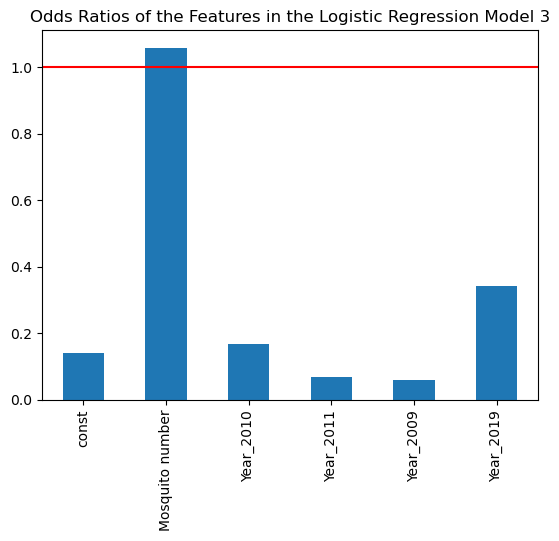

In [124]:
#visualize the exponentiated coefficients
plt.figure()
np.exp(LR3_bfs_results.params).plot(kind='bar')
plt.title('Odds Ratios of the Features in the Logistic Regression Model 3')
plt.axhline(1, color='red')
plt.show()

Only the `Mosquito number` feature is positively correlated with the WNV presence. With 1 unit of increase in the `Mosqito number`, the odds of WNV presence increases by a factor of 1.05. In contrast, `Year_2019` has negative correlation with the WNV Presence. If the year is 2019, the WNV presence decreases by 0.05.

**Model Accuracy**

In [125]:
probpreds3 = LR3_bfs_results.predict(newX_withC2)  #get the probability predictions

classpreds3 = np.where(probpreds3>0.5, 1, 0) #set the threshold at 0.5

(classpreds3 == y).sum() #gives the number of rows that were predicted correctly

acc3 = (classpreds3 == y).sum() / len(y) #calculate the accuracy

print(acc3)

0.8196445590626227


We actually made our model worse by dropping so many features. Its accuracy has decreased from 83% to ~82%, which is only 1% improvement upon the baseline (81%). We can again check if it performs better at different thresholds. The answer is probably no. 

In [126]:
accuracies = []

THvals = np.arange(0.01, 0.99, 0.01)

for TH in THvals:
    classpreds3 = np.where(probpreds3>TH, 1, 0)
    accuracy = ((classpreds3 == y).sum()) / len(y)
    accuracies.append(accuracy)

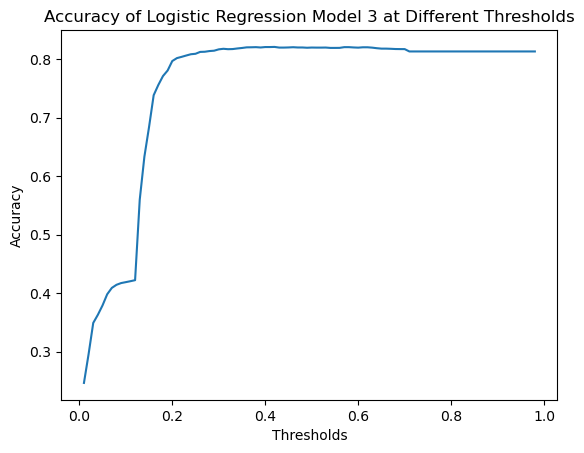

In [127]:
plt.figure()
plt.plot(THvals, accuracies)
plt.title('Accuracy of Logistic Regression Model 3 at Different Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
plt.show()

As expected, different thresholds do not improve this model either. 

Let's add back a few more features and see what happens.

### The Fourth and Final Logistic Regression Model: LR4

In [128]:
LR2_bfs_results.pvalues.sort_values().index #sort the columns of the model before the last one based on p-values

Index(['Mosquito number', 'Year_2010', 'Year_2011', 'Year_2009', 'Year_2019',
       'Year_2008', 'Year_2015', 'Year_2016', 'Is_Midnight',
       'Is_RestuansPipiens', 'Year_2014', 'const', 'Lon', 'Is_Summer_Month',
       'Year_2013', 'Year_2017'],
      dtype='object')

In [129]:
newX_withC3 = newX[['Mosquito number', 'Year_2010', 'Year_2011', 'Year_2009', 'Year_2019',
                    'Year_2008', 'Year_2015', 'Year_2016', 'Is_Midnight', 'Is_RestuansPipiens']] 

newX_withC3 = sm.add_constant(newX_withC3) #add the constant

newX_withC3.head()

,const,Mosquito number,Year_2010,Year_2011,Year_2009,Year_2019,Year_2008,Year_2015,Year_2016,Is_Midnight,Is_RestuansPipiens
0,1.0,2,0,0,0,1,0,0,0,1,1
1,1.0,1,0,0,0,1,0,0,0,1,1
2,1.0,2,0,0,0,1,0,0,0,1,1
3,1.0,1,0,0,0,1,0,0,0,1,1
4,1.0,9,0,0,0,1,0,0,0,1,1


In [130]:
LR4_bfs = sm.Logit(y, newX_withC3) #instantiate

LR4_bfs_results = LR4_bfs.fit() #fit

LR4_bfs_results.summary() #get summary

Optimization terminated successfully.
         Current function value: 0.373955
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                17837
Model:                          Logit   Df Residuals:                    17826
Method:                           MLE   Df Model:                           10
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                  0.2240
Time:                        09:23:26   Log-Likelihood:                -6670.2
converged:                       True   LL-Null:                       -8595.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.8269      0.353    -16.500      0.000      -6.519      -5.135
Mosquito number        0.0483      0.001     33.584      0.000       0.045       0.051
Year_2010             -1.7683      0.150    -11.757      0.000      -2.063      -1.474
Year_2011             -2.7081      0.235    -11.523      0.000      -3.169      -2.247
Year_2009             -2.9404      0.271    -10.833      0.000      -3.472      -2.408
Year_2019             -1.1060      0.111     -9.958      0.000      -1.324      -0.888
Year_2008             -2.2756      0.223    -10.187      0.000      -2.713      -1.838
Year_2015             -0.7815      0.099     -7.918      0.000      -0.975      -0.588
Year_2016              0.7616      0.059     12.924      0.000       0.646       0.877
Is_Midnight            2.2452      0.276      8.137      0.000       1.704       2.786
Is_RestuansPipiens     1.8336      0.224      8.184      0.000       1.394       2.273
======================================================================================
"""

**Model Interpretation**

All the features and the constant have p-values near 0. Let's check the odds ratios!

In [131]:
np.exp(LR4_bfs_results.params) #get the odds ratios

const                 0.002947
Mosquito number       1.049498
Year_2010             0.170622
Year_2011             0.066660
Year_2009             0.052843
Year_2019             0.330894
Year_2008             0.102732
Year_2015             0.457737
Year_2016             2.141717
Is_Midnight           9.442472
Is_RestuansPipiens    6.256356
dtype: float64

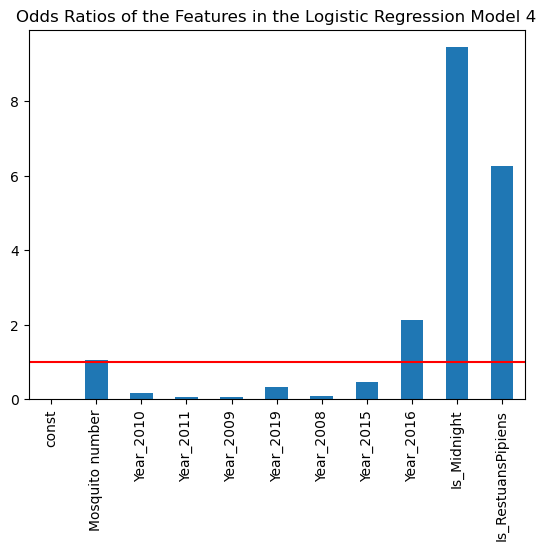

In [132]:
#visualize the exponentiated coefficients
plt.figure()
np.exp(LR4_bfs_results.params).plot(kind='bar')
plt.title('Odds Ratios of the Features in the Logistic Regression Model 4')
plt.axhline(1, color='red')
plt.show()

All the year features except for 2016 have a negative correlation with the WNV presence. If the year is 2016, the odds of WNV presence increases by a factor of 2.1. Let's check the accuracy of the model!

**Model Accuracy**

In [133]:
probpreds4 = LR4_bfs_results.predict(newX_withC3)  #get the probability predictions

classpreds4 = np.where(probpreds4>0.5, 1, 0) #set the threshold at 0.5

(classpreds4 == y).sum() #gives the number of rows that were predicted correctly

acc4 = (classpreds4 == y).sum() / len(y) #calculate the accuracy

print(acc4)

0.8300162583394068


Model accuracy is back to 83%, which is the same as the second model that included all the features with a p-value lower than 0.05. This is again only a little improvement upon the 81% baseline. Let's check if it performs better at different thresholds. The answer is probably no.

In [134]:
accuracies = []

THvals = np.arange(0.01, 0.99, 0.01)

for TH in THvals:
    classpreds4 = np.where(probpreds4>TH, 1, 0)
    accuracy = ((classpreds4 == y).sum()) / len(y)
    accuracies.append(accuracy)

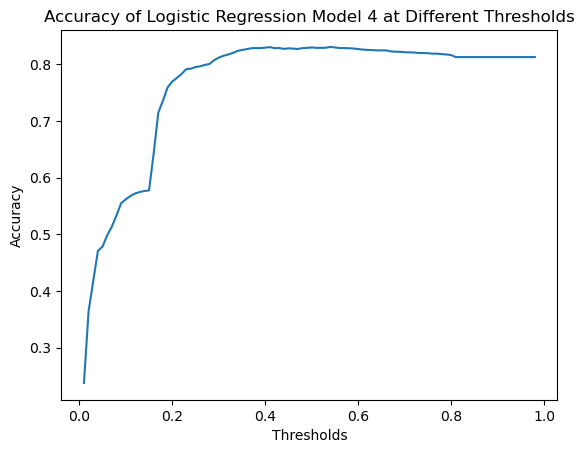

In [135]:
plt.figure()
plt.plot(THvals, accuracies)
plt.title('Accuracy of Logistic Regression Model 4 at Different Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
plt.show()

Similar to before, the model does not improve at different thresholds. Its maximum accuracy seems to be around 83%, which is only a little improvement over the 81% baseline if we guessed 0 every time. This is due to the class imbalance in the data. 81% of the `WNV Present` column is 0 while 19% is 1. 

**In conclusion**, we can go back and do the data preprocessing differently but with the big class imbalance in the data, but it is very unlikely that we can build a much better logistic regression model. We fail to reject the null that there is no relationship between WNV presence and the columns in the dataframe. 